# Practical Factor Investing: Dimensional, Avantis, and Portfolio Construction

## From Theory to Practice — Analysing Real Factor ETFs with the Tools We've Built

---

### Where This Fits

This is the fifth notebook in the series. The recommended reading order is:

1. **[Statistical Foundations](01_Statistical_Foundations.ipynb)** — CLT, hypothesis testing, OLS, sandwich estimators, Newey-West derivation
2. **[Time Series Foundations](02_Time_Series_Foundations.ipynb)** — Stationarity, autocorrelation, volatility clustering, ergodicity
3. **[Fama-French 3-Factor Model](03_Fama_French_3Factor.ipynb)** — Data, regression mechanics, diagnostics, robust SEs, interpretation
4. **[Advanced Factor Models](04_Advanced_Factor_Models.ipynb)** — FF5, momentum, profitability, beta anomaly, Chen's challenge, rolling windows
5. **Practical Factor Investing** — this notebook

The previous notebooks gave us the *theory*, the *statistical tools*, and the *research landscape*. This notebook asks: **how do real-world fund managers translate factor research into investable products — and can we verify their claims using the methods we've learned?**

### What We'll Cover

1. **The Dimensional and Avantis Investment Philosophies** — How these firms implement academic factor research, their scientific approach, and what distinguishes them from traditional index funds
2. **Data: Avantis UCITS ETFs on Xetra** — Loading daily return data for AVWS, AVWC, and AVEM alongside global Fama-French factors
3. **Descriptive Analysis** — Return distributions, volatility, drawdowns, and how these ETFs compare
4. **Factor Regression Analysis** — Applying FF5 + Momentum regressions to identify each ETF's factor exposures, with full diagnostic checks
5. **Comparative Factor Profiles** — Visualising how the ETFs differ in their factor tilts and what that implies
6. **Portfolio Construction** — Building a 50% AVWS / 40% AVWC / 10% AVEM portfolio and analysing its risk-return characteristics
7. **Portfolio Factor Analysis** — Running factor regressions on the combined portfolio
8. **Limitations and Conclusions** — What we can and cannot conclude from limited data

### A Note on Data Limitations

> **Important caveat (March 2026):** The Avantis UCITS ETFs launched on European exchanges in late 2024. We have approximately **17 months of daily data** for AVWS and AVWC, and roughly **15 months** for AVEM. This is a *very* short sample for drawing definitive conclusions about factor exposures and alpha.
>
> What we **can** do with daily data:
> - Identify factor **tilts** (betas) with reasonable statistical precision — 300+ daily observations gives enough power for point estimates
> - Characterise the return distribution and risk profile
> - Illustrate how the analytical tools from earlier notebooks apply to real portfolios
>
> What we **cannot** do reliably:
> - Estimate alpha with tight confidence intervals
> - Draw conclusions about long-term performance
> - Compare realised premia to historical averages (the sample is too short)
>
> This notebook is therefore as much a **methodology demonstration** as a performance evaluation. The tools we apply here will remain valid as the data history grows.

### Prerequisites

All four preceding notebooks. We use:
- **OLS regression with Newey-West standard errors** ([Notebook 1, Section 7](01_Statistical_Foundations.ipynb))
- **Autocorrelation and volatility clustering diagnostics** ([Notebook 2, Sections 3-4](02_Time_Series_Foundations.ipynb))
- **Factor regression mechanics and interpretation** ([Notebook 3](03_Fama_French_3Factor.ipynb))
- **The FF5 + Momentum model and its interpretation** ([Notebook 4, Sections 1-2](04_Advanced_Factor_Models.ipynb))
- **The DFA/Avantis implementation philosophy** ([Notebook 4, Section 6](04_Advanced_Factor_Models.ipynb))

---

## Section 1: The Dimensional and Avantis Investment Philosophies

### 1.1 Dimensional Fund Advisors — The Original Factor Firm

Dimensional was founded in 1981 by David Booth and Rex Sinquefield, with direct guidance from Eugene Fama and Kenneth French (who serve as consultants and board members). Having crossed $1 trillion USD in AUM, Dimensional is the largest firm built entirely on academic factor research.

**Core Investment Philosophy:**
- Markets are broadly efficient — don't try to pick stocks or time the market
- Academic research identifies **reliable dimensions of higher expected returns**: market, size, value, and profitability
- **Systematically tilt** portfolios toward small-cap, value, and profitable stocks
- Use **patient, low-cost trading** — don't track an index mechanically, but trade opportunistically to minimise costs
- **Broad diversification** within the tilt — hold thousands of stocks, not concentrated bets

**The Integrated Approach (from Wei Dai, Rational Reminder Episode 306):**

As discussed in [Notebook 4, Section 6.4](04_Advanced_Factor_Models.ipynb), Dimensional's key innovation is the **integrated multi-factor portfolio**. Rather than buying separate value, size, and profitability funds (the "combination" approach) or adding a concentrated factor satellite to a core holding, DFA does a **three-way simultaneous sort** on size, value, and profitability:

- Start with the entire market
- Score every stock on all three dimensions at once
- Gradually shift weight toward stocks with higher expected returns across *all* dimensions
- Use a **multiplier system**: each stock's weight = market-cap weight x multiplier (e.g., 2x for high-expected-return segments, 0.5x for low)

This avoids the problem identified by Novy-Marx ([Notebook 4, Section 6.9](04_Advanced_Factor_Models.ipynb)): buying a value fund and a profitability fund separately can **cancel out** factor exposures, because value stocks tend to score low on profitability and vice versa.

**Key Implementation Details:**
- **No hard rebalancing dates** — daily rebalancing ranges instead of quarterly index reconstitution
- **Momentum as an exclusion screen** — delay buying stocks with negative momentum (avoids "catching falling knives")
- **Reversal screens** — based on Dai & Novy-Marx (2024), delay trading when short-term reversals suggest adverse selection
- **8,000–12,000 stocks** per portfolio — extreme diversification to capture Bessembinder's insight that only 4% of stocks drive all wealth creation ([Notebook 4, Section 6.5](04_Advanced_Factor_Models.ipynb))

**Dimensional UCITS ETFs:**
Dimensional launched UCITS-compliant ETFs for European investors, including DEGC (Global Core Equity) and DEGT (Global Targeted Value). However, these launched only in late 2025, making their data history too short for meaningful statistical analysis at this time.

### 1.2 Avantis Investors — The Scientific Approach

Avantis was founded in 2019 by Eduardo Repetto (former CIO of Dimensional) and a team of ex-DFA researchers. Their approach builds on the Dimensional foundation but introduces several refinements.

**The "Scientific Approach to Investing"**

Avantis' investment philosophy, as outlined in their institutional research documents, rests on three pillars:

**Pillar 1: Markets Are Broadly Efficient, But Expected Returns Vary**
- Security prices reflect available information quickly and accurately *most of the time*
- However, expected returns are **not equal across all stocks** — some characteristics (value, profitability) are associated with higher expected returns
- This is not a contradiction: efficient markets can still offer different expected returns as compensation for different levels of risk

**Pillar 2: Identify Reliable Drivers of Expected Returns**
- Use economic theory and empirical evidence to identify characteristics that predict cross-sectional return differences
- Focus on characteristics that are: (a) persistent across time, (b) pervasive across markets, (c) robust to different measurement approaches, (d) grounded in economic intuition
- Avantis focuses on two primary signals:
  - **Valuation ratios** (book-to-market, earnings yield) — the value dimension
  - **Cash-flow-based profitability** — the profitability dimension
- These are combined into a single **composite expected return** score for each stock

**Pillar 3: Thoughtful Portfolio Construction Minimises Costs**
- The gap between theoretical factor returns and realisable returns is large (as Chen & Velikov documented — [Notebook 4, Section 7](04_Advanced_Factor_Models.ipynb))
- Avantis explicitly designs portfolios to **minimise the implementation shortfall**:
  - Broad diversification (thousands of holdings)
  - Integrated multi-factor sorting (not separate factor sleeves)
  - Patient, spread-sensitive trading
  - Momentum and reversal signals used to **time trades**, not as standalone factors

**Key Differences from Dimensional:**

| Dimension | Dimensional | Avantis |
|-----------|-------------|---------|
| **Sorting method** | Independent sorts on size × value × profitability, then multiplier weights | Composite expected-return score combining value + profitability |
| **Philosophy** | Three-way sort with gradual tilts | Rank all stocks by expected return, overweight the top |
| **Concentration** | Very broad (8,000–12,000 stocks) | Somewhat more concentrated (still thousands of stocks) |
| **Distribution** | Historically advisor-only; now also ETFs | ETF-first from launch |
| **Momentum use** | Exclusion screen only (avoid negative momentum) | Timing signal for trade execution |
| **Fee structure** | Competitive (0.15–0.35%) | Very competitive (0.15–0.25%) |

**The Avantis UCITS ETFs We'll Analyse:**

| Ticker | Full Name | Strategy | Launch (Xetra) |
|--------|-----------|----------|-----------------|
| **AVWS** | Avantis Global Small Cap Value UCITS ETF | Small-cap stocks screened for value + profitability worldwide | October 2024 |
| **AVWC** | Avantis Global Equity UCITS ETF | All-cap global equity with value + profitability tilts | October 2024 |
| **AVEM** | Avantis Emerging Markets Equity UCITS ETF | EM equity with value + profitability tilts | December 2024 |

**What we expect to find in factor regressions:**
- **AVWS**: Positive SMB (small-cap) and positive HML (value tilt). Avantis screens for profitability, so we might expect a positive RMW loading, though this depends on how the profitability screen interacts with the value tilt in practice. This should look like a small-cap value fund.
- **AVWC**: A significant market beta, modest positive HML and RMW (broad market with gentle tilts). Note: the measured beta may be attenuated below 1.0 due to **non-synchronous trading** — these ETFs trade on Xetra (European hours) while the Developed Markets factors include US stocks that close hours later. This classic microstructure effect biases daily betas downward.
- **AVEM**: Market beta near 1 for EM, with positive HML. May show different factor loadings due to EM-specific characteristics. With only ~15 monthly observations, we should expect wide confidence intervals.

### 1.3 The Rational Reminder Perspective

The [Rational Reminder podcast](https://rationalreminder.ca/) (Ben Felix and Cameron Passmore) has become one of the most influential voices in evidence-based investing. Their framework for factor investing with ETFs aligns closely with what we'll analyse:

1. **Core market exposure** supplemented by **factor tilts** (especially small-cap value + profitability)
2. **Global diversification** across regions
3. **Systematic rebalancing** with discipline through drawdowns
4. **Fee awareness** — even small differences compound over decades

The portfolio we construct in Section 6 (50% AVWS / 40% AVWC / 10% AVEM) represents a **globally diversified, factor-tilted equity allocation** — exactly the type of portfolio this research tradition recommends.

### 1.4 How This Connects to the Academic Research

The academic threads from [Notebook 4](04_Advanced_Factor_Models.ipynb) converge in these products:

| Academic Finding | How DFA/Avantis Implement It |
|-----------------|------------------------------|
| Value + profitability interaction (Novy-Marx, 2013) | Integrated multi-factor sort — no cancellation of exposures |
| Transaction cost erosion (Chen & Velikov, 2023) | Patient trading, reversal screens, no forced rebalancing dates |
| Momentum crash risk (Daniel & Moskowitz, 2016) | Momentum as exclusion/timing screen, not as a held position |
| Bessembinder's skewness (2018) | Extreme diversification (thousands of holdings) |
| Wei Dai's 720 timing strategies (2023) | No premium timing — constant exposure to return dimensions |
| Adaptive Markets (Lo, 2017; Chen, 2024) | Continuous research cycle; willingness to update methodology |

The question we can begin to answer with data: **do the factor exposures we observe in these ETFs match what the firms claim?**

In [1]:
# ============================================================================
# Setup: Import Libraries
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
import yfinance as yf
import urllib.request
import zipfile
import tempfile
import os
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


---

## Section 2: Data — Avantis UCITS ETFs and Fama-French Factors

We need two datasets:

1. **Daily ETF prices** from Xetra (via Yahoo Finance) for AVWS, AVWC, and AVEM
2. **Fama-French 5 factors + Momentum** from Kenneth French's data library

### Matching Factors to Investment Universes

A crucial methodological choice is **which regional factor set** to regress each ETF against. The Fama-French data library provides factors constructed from different investment universes:

- **Developed Markets factors (daily)** — Constructed from stocks in 23 developed markets (including the US). Available through the present. This is the correct match for **AVWS** (Global Small Cap Value) and **AVWC** (Global Equity), since both invest predominantly in developed-market equities.

- **Emerging Markets factors (monthly only)** — Constructed from EM stocks. Available monthly through the present, but **no daily frequency** is provided. This is the theoretically correct match for **AVEM** (Emerging Markets Equity).

**Our approach:**
- **AVWS** and **AVWC**: Regressed against **Developed Markets daily factors** — a proper match.
- **AVEM**: Regressed against **Emerging Markets monthly factors** only. Regressing an EM fund against developed-market factors would be a model misspecification, not merely a noisy proxy — the DM factors (Mkt-RF, SMB, HML, etc.) are constructed from an entirely different investment universe and would tell us about co-movement with developed markets, not about AVEM's actual factor tilts within emerging markets. With only ~15 monthly observations the EM regression is statistically limited, but it asks the right question.
- **Portfolio-level regressions** (Section 7) use Developed Markets factors for the combined 50/40/10 portfolio, which is appropriate given its 90% developed-market weight.

> **Currency note:** The ETFs trade in EUR on Xetra, while the Fama-French factors are computed in USD. We convert ETF returns to USD using the EUR/USD exchange rate. This ensures our factor loadings are not contaminated by currency movements. The betas are relatively robust to this conversion (since currency effects are largely orthogonal to factor returns), but the alpha estimate would be meaningfully affected without it.

In [2]:
# ============================================================================
# Step 1: Download Fama-French Factors (Developed Markets Daily + EM Monthly)
# ============================================================================

def load_ff_csv_from_zip(url, skip_footer=0):
    """Download and parse a Fama-French CSV from a zip file."""
    with tempfile.TemporaryDirectory() as tmpdir:
        zip_path = os.path.join(tmpdir, 'data.zip')
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as z:
            csv_name = [f for f in z.namelist() if f.endswith('.CSV') or f.endswith('.csv')][0]
            with z.open(csv_name) as f:
                lines = f.read().decode('utf-8').splitlines()
    
    # Find the header row (contains 'Mkt-RF' or 'WML' or 'Mom')
    header_idx = None
    for i, line in enumerate(lines):
        if 'Mkt-RF' in line or 'WML' in line or 'Mom' in line:
            header_idx = i
            break
    
    if header_idx is None:
        raise ValueError("Could not find header row in CSV")
    
    # Parse from header row
    from io import StringIO
    data_text = '\n'.join(lines[header_idx:])
    df = pd.read_csv(StringIO(data_text), index_col=0)
    
    # Clean: remove non-numeric rows and annual data section
    df.index = df.index.astype(str).str.strip()
    
    # Detect frequency: YYYYMMDD (daily) or YYYYMM (monthly)
    daily_rows = df[df.index.str.match(r'^\d{8}$')]
    monthly_rows = df[df.index.str.match(r'^\d{6}$')]
    
    if len(daily_rows) > 0:
        df = daily_rows
        df.index = pd.to_datetime(df.index, format='%Y%m%d')
    elif len(monthly_rows) > 0:
        df = monthly_rows
        df.index = pd.to_datetime(df.index, format='%Y%m')
    else:
        raise ValueError("No valid date rows found")
    
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna()
    
    return df

# ---- Developed Markets Factors (Daily) — for AVWS and AVWC ----
print("Loading Developed Markets Fama-French 5 Factors (Daily)...")
ff5_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_5_Factors_Daily_CSV.zip'
ff5 = load_ff_csv_from_zip(ff5_url)
ff5.columns = ff5.columns.str.strip()
ff5 = ff5.rename(columns={'Mkt-RF': 'Mkt_RF'})

print(f"  Shape: {ff5.shape}")
print(f"  Date range: {ff5.index[0].date()} to {ff5.index[-1].date()}")
print(f"  Columns: {list(ff5.columns)}")

print("\nLoading Developed Markets Momentum Factor (Daily)...")
mom_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Developed_Mom_Factor_Daily_CSV.zip'
mom = load_ff_csv_from_zip(mom_url)
mom.columns = mom.columns.str.strip()
mom_col = mom.columns[0]  # Usually 'WML'
mom = mom.rename(columns={mom_col: 'UMD'})

print(f"  Shape: {mom.shape}")
print(f"  Date range: {mom.index[0].date()} to {mom.index[-1].date()}")

# Merge Developed FF5 + Momentum
factors = ff5.join(mom[['UMD']], how='inner')

print(f"\nCombined Developed Markets factors (FF5 + Momentum): {factors.shape}")
print(f"  Columns: {list(factors.columns)}")

# ---- Emerging Markets Factors (Monthly) — for AVEM supplementary analysis ----
print("\n" + "-"*70)
print("Loading Emerging Markets Fama-French 5 Factors (Monthly)...")
em_ff5_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Emerging_5_Factors_CSV.zip'
em_ff5 = load_ff_csv_from_zip(em_ff5_url)
em_ff5.columns = em_ff5.columns.str.strip()
em_ff5 = em_ff5.rename(columns={'Mkt-RF': 'Mkt_RF'})

print(f"  Shape: {em_ff5.shape}")
print(f"  Date range: {em_ff5.index[0].date()} to {em_ff5.index[-1].date()}")
print(f"  Columns: {list(em_ff5.columns)}")

print("\nLoading Emerging Markets Momentum Factor (Monthly)...")
em_mom_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Emerging_Mom_Factor_CSV.zip'
em_mom = load_ff_csv_from_zip(em_mom_url)
em_mom.columns = em_mom.columns.str.strip()
em_mom_col = em_mom.columns[0]
em_mom = em_mom.rename(columns={em_mom_col: 'UMD'})

print(f"  Shape: {em_mom.shape}")
print(f"  Date range: {em_mom.index[0].date()} to {em_mom.index[-1].date()}")

# Merge EM FF5 + Momentum (monthly)
em_factors = em_ff5.join(em_mom[['UMD']], how='inner')

print(f"\nCombined Emerging Markets factors (FF5 + Momentum, monthly): {em_factors.shape}")
print(f"  Columns: {list(em_factors.columns)}")

print(f"\nSample Developed Markets factors (last 5 rows):")
print(factors.tail())

Loading Developed Markets Fama-French 5 Factors (Daily)...
  Shape: (9285, 6)
  Date range: 1990-07-02 to 2026-01-30
  Columns: ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

Loading Developed Markets Momentum Factor (Daily)...
  Shape: (9197, 1)
  Date range: 1990-11-01 to 2026-01-30

Combined Developed Markets factors (FF5 + Momentum): (9197, 7)
  Columns: ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'UMD']

----------------------------------------------------------------------
Loading Emerging Markets Fama-French 5 Factors (Monthly)...
  Shape: (439, 6)
  Date range: 1989-07-01 to 2026-01-01
  Columns: ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

Loading Emerging Markets Momentum Factor (Monthly)...
  Shape: (433, 1)
  Date range: 1990-01-01 to 2026-01-01

Combined Emerging Markets factors (FF5 + Momentum, monthly): (433, 7)
  Columns: ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'UMD']

Sample Developed Markets factors (last 5 rows):
            Mkt_RF   SMB   HML   RMW   CMA    RF

In [3]:
# ============================================================================
# Step 2: Download Avantis UCITS ETF Prices from Xetra + EUR/USD FX Rate
# ============================================================================

etf_tickers = {
    'AVWS.DE': 'Avantis Global Small Cap Value',
    'AVWC.DE': 'Avantis Global Equity',
    'AVEM.DE': 'Avantis Emerging Markets Equity',
}

print("="*70)
print("DOWNLOADING AVANTIS UCITS ETF DATA (XETRA)")
print("="*70)

# Download ETF prices
etf_prices = {}
for ticker, name in etf_tickers.items():
    data = yf.download(ticker, period='max', progress=False)
    # Handle multi-level columns from yfinance
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    etf_prices[ticker] = data['Close']
    print(f"\n{ticker} ({name}):")
    print(f"  Observations: {len(data)}")
    print(f"  Date range: {data.index[0].date()} to {data.index[-1].date()}")
    print(f"  First price: {data['Close'].iloc[0]:.2f} EUR")
    print(f"  Last price: {data['Close'].iloc[-1]:.2f} EUR")

# Download EUR/USD exchange rate
print("\n" + "-"*70)
print("Downloading EUR/USD exchange rate...")
fx_data = yf.download('EURUSD=X', start='2024-09-01', progress=False)
if isinstance(fx_data.columns, pd.MultiIndex):
    fx_data.columns = fx_data.columns.get_level_values(0)
eurusd = fx_data['Close']
print(f"  Observations: {len(eurusd)}")
print(f"  Date range: {eurusd.index[0].date()} to {eurusd.index[-1].date()}")

# Compute daily returns in EUR, then convert to USD
print("\n" + "="*70)
print("COMPUTING DAILY RETURNS (USD-CONVERTED)")
print("="*70)

etf_returns_usd = {}
for ticker, name in etf_tickers.items():
    prices_eur = etf_prices[ticker]
    
    # Daily EUR returns
    ret_eur = prices_eur.pct_change().dropna()
    
    # EUR/USD rate changes
    fx_aligned = eurusd.reindex(ret_eur.index, method='ffill')
    fx_ret = fx_aligned.pct_change()
    
    # Convert to USD: R_usd ≈ R_eur + R_fx + R_eur * R_fx
    # For daily returns, the cross-term is negligible
    ret_usd = ret_eur + fx_ret + ret_eur * fx_ret
    ret_usd = ret_usd.dropna()
    
    # Convert to percentage points to match FF factor data
    etf_returns_usd[ticker] = ret_usd * 100
    
    print(f"\n{ticker} ({name}):")
    print(f"  Daily return obs: {len(ret_usd)}")
    print(f"  Mean daily return: {ret_usd.mean()*100:.4f}%")
    print(f"  Daily volatility: {ret_usd.std()*100:.4f}%")
    print(f"  Ann. return (approx): {ret_usd.mean()*252*100:.2f}%")
    print(f"  Ann. volatility (approx): {ret_usd.std()*np.sqrt(252)*100:.2f}%")

DOWNLOADING AVANTIS UCITS ETF DATA (XETRA)

AVWS.DE (Avantis Global Small Cap Value):
  Observations: 354
  Date range: 2024-10-03 to 2026-02-27
  First price: 17.92 EUR
  Last price: 22.71 EUR

AVWC.DE (Avantis Global Equity):
  Observations: 354
  Date range: 2024-10-03 to 2026-02-27
  First price: 18.11 EUR
  Last price: 22.20 EUR

AVEM.DE (Avantis Emerging Markets Equity):
  Observations: 304
  Date range: 2024-12-12 to 2026-02-27
  First price: 19.15 EUR
  Last price: 25.62 EUR

----------------------------------------------------------------------
  Observations: 385
  Date range: 2024-09-02 to 2026-02-27

COMPUTING DAILY RETURNS (USD-CONVERTED)

AVWS.DE (Avantis Global Small Cap Value):
  Daily return obs: 352
  Mean daily return: 0.0901%
  Daily volatility: 1.2274%
  Ann. return (approx): 22.71%
  Ann. volatility (approx): 19.48%

AVWC.DE (Avantis Global Equity):
  Daily return obs: 352
  Mean daily return: 0.0795%
  Daily volatility: 1.0226%
  Ann. return (approx): 20.03%
  An

In [4]:
# ============================================================================
# Step 3: Merge ETF Returns with Factor Data
# ============================================================================

print("="*70)
print("MERGING ETF RETURNS WITH FAMA-FRENCH FACTORS")
print("="*70)

# ---- Daily: All three ETFs merged with Developed Markets factors ----
# (AVWS/AVWC use these for individual regressions; AVEM needs it for
# the portfolio construction in Section 6 and descriptive statistics only.)
etf_dataframes = {}
for ticker, name in etf_tickers.items():
    ret = etf_returns_usd[ticker]
    
    # Merge with Developed Markets factors on date
    merged = pd.DataFrame({'ETF_Return': ret})
    merged = merged.join(factors, how='inner')
    
    # Compute excess return: ETF return - risk-free rate
    merged['Excess_Return'] = merged['ETF_Return'] - merged['RF']
    
    etf_dataframes[ticker] = merged
    
    if ticker != 'AVEM.DE':
        print(f"\n{ticker} ({name}) — Developed Markets daily factors:")
    else:
        print(f"\n{ticker} ({name}) — DM factors (for portfolio use; see EM monthly for regressions):")
    print(f"  Matched observations: {len(merged)}")
    if len(merged) > 0:
        print(f"  Date range: {merged.index[0].date()} to {merged.index[-1].date()}")
        print(f"  Mean excess return: {merged['Excess_Return'].mean():.4f}%/day")
    else:
        print("  WARNING: No matching dates found!")

# ---- Monthly: AVEM merged with Emerging Markets factors ----
print("\n" + "-"*70)
print("AVEM — EMERGING MARKETS MONTHLY FACTOR DATA")
print("-"*70)

# Compute AVEM monthly returns from daily (USD-converted, in % units)
avem_daily_ret = etf_returns_usd['AVEM.DE'] / 100  # Convert back to decimal
avem_monthly_ret = (1 + avem_daily_ret).resample('ME').prod() - 1
avem_monthly_ret = avem_monthly_ret * 100  # Back to % units to match FF data

# Merge with EM monthly factors
avem_monthly_df = pd.DataFrame({'ETF_Return': avem_monthly_ret})
# EM factors are dated at month start; align by shifting ETF to month start
avem_monthly_df.index = avem_monthly_df.index.to_period('M').to_timestamp()
avem_monthly_df = avem_monthly_df.join(em_factors, how='inner')
avem_monthly_df['Excess_Return'] = avem_monthly_df['ETF_Return'] - avem_monthly_df['RF']

print(f"  Monthly observations: {len(avem_monthly_df)}")
if len(avem_monthly_df) > 0:
    print(f"  Date range: {avem_monthly_df.index[0].date()} to {avem_monthly_df.index[-1].date()}")
    print(f"  Mean monthly excess return: {avem_monthly_df['Excess_Return'].mean():.2f}%")
else:
    print("  WARNING: No matching months found!")

# Summary
print("\n" + "="*70)
print("DATA SUMMARY")
print("="*70)
print(f"{'ETF':<12} {'Obs':>6} {'Start':>12} {'End':>12} {'Ann. Ret':>10} {'Ann. Vol':>10} {'Factors'}")
print("-"*85)
for ticker, name in etf_tickers.items():
    df = etf_dataframes[ticker]
    ann_ret = df['Excess_Return'].mean() * 252
    ann_vol = df['Excess_Return'].std() * np.sqrt(252)
    flabel = "Developed (daily)" if ticker != 'AVEM.DE' else "DM (portfolio only)"
    print(f"{ticker:<12} {len(df):>6} {df.index[0].strftime('%Y-%m-%d'):>12} "
          f"{df.index[-1].strftime('%Y-%m-%d'):>12} {ann_ret:>9.2f}% {ann_vol:>9.2f}%  {flabel}")

print(f"{'AVEM(EM mo)':<12} {len(avem_monthly_df):>6} {avem_monthly_df.index[0].strftime('%Y-%m-%d'):>12} "
      f"{avem_monthly_df.index[-1].strftime('%Y-%m-%d'):>12} "
      f"{avem_monthly_df['Excess_Return'].mean()*12:>9.2f}% "
      f"{avem_monthly_df['Excess_Return'].std()*np.sqrt(12):>9.2f}%  EM (monthly)")

MERGING ETF RETURNS WITH FAMA-FRENCH FACTORS

AVWS.DE (Avantis Global Small Cap Value) — Developed Markets daily factors:
  Matched observations: 332
  Date range: 2024-10-07 to 2026-01-30
  Mean excess return: 0.0641%/day

AVWC.DE (Avantis Global Equity) — Developed Markets daily factors:
  Matched observations: 332
  Date range: 2024-10-07 to 2026-01-30
  Mean excess return: 0.0616%/day

AVEM.DE (Avantis Emerging Markets Equity) — DM factors (for portfolio use; see EM monthly for regressions):
  Matched observations: 282
  Date range: 2024-12-16 to 2026-01-30
  Mean excess return: 0.1219%/day

----------------------------------------------------------------------
AVEM — EMERGING MARKETS MONTHLY FACTOR DATA
----------------------------------------------------------------------
  Monthly observations: 14
  Date range: 2024-12-01 to 2026-01-01
  Mean monthly excess return: 2.38%

DATA SUMMARY
ETF             Obs        Start          End   Ann. Ret   Ann. Vol Factors
-------------------

---

## Section 3: Descriptive Analysis

Before running factor regressions, we examine the basic statistical properties of these ETFs. This connects directly to [Notebook 2](02_Time_Series_Foundations.ipynb): financial return series typically exhibit fat tails, volatility clustering, and weak autocorrelation — features that our regression approach (Newey-West SEs) is designed to handle.

DESCRIPTIVE STATISTICS — DAILY EXCESS RETURNS (% per day)
        N Mean (%) Std (%) Skewness Kurtosis JB p-value LB(5) p LB²(5) p Min (%) Max (%)
ETF                                                                                     
AVWS  332   0.0641  1.2455   -0.329    7.590     0.0000  0.6933   0.0006   -6.13    6.40
AVWC  332   0.0616  1.0416   -0.327    6.463     0.0000  0.0497   0.0000   -4.29    4.18
AVEM  282   0.1219  1.1252   -0.167    4.938     0.0000  0.0978   0.0000   -4.03    4.01

INTERPRETATION:
━━━━━━━━━━━━━━
• JB p-value < 0.05 → Returns are NOT normally distributed (expected for 
  financial data, as discussed in Notebook 2, Section 1)

• LB(5) p-value: Tests for autocorrelation in returns. 
  p < 0.05 → significant autocorrelation detected

• LB²(5) p-value: Tests for autocorrelation in SQUARED returns 
  (volatility clustering). p < 0.05 → ARCH effects present
  (as expected from Notebook 2, Section 4)

→ These diagnostics confirm that Newey-West standard errors

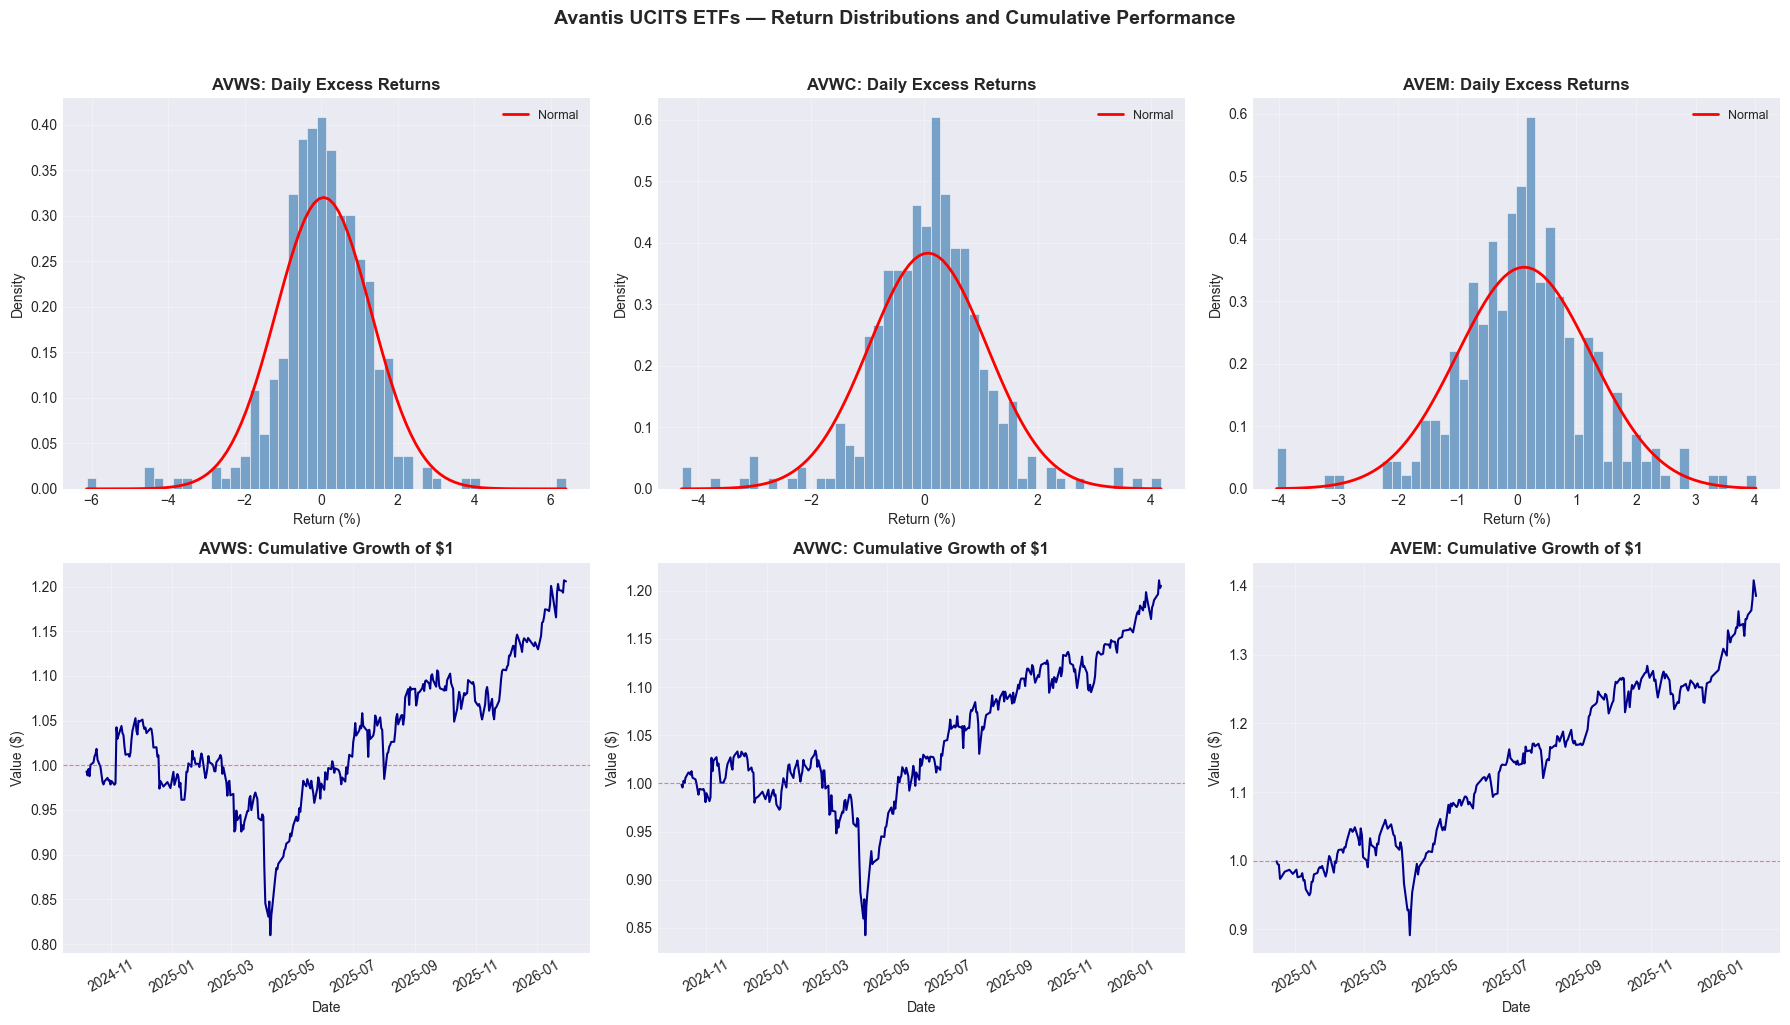


TOP ROW: Return distributions. Compare the histogram to the red normal curve.
Fat tails (excess kurtosis) are visible — returns have more extreme observations 
than a normal distribution would predict. This motivates robust standard errors.

BOTTOM ROW: Cumulative returns since inception. Remember: this is a very short 
period (~17 months). Short-term performance is dominated by market movements and 
luck, not factor premia (which require 10-20 year horizons per Wei Dai's research).



In [5]:
# ============================================================================
# Descriptive Statistics and Return Distributions
# ============================================================================

print("="*70)
print("DESCRIPTIVE STATISTICS — DAILY EXCESS RETURNS (% per day)")
print("="*70)

desc_stats = []
for ticker, name in etf_tickers.items():
    r = etf_dataframes[ticker]['Excess_Return']
    jb_stat, jb_p, skew_val, kurt_val = jarque_bera(r)
    
    # Ljung-Box test for autocorrelation (lag 5)
    lb_result = acorr_ljungbox(r, lags=[5], return_df=True)
    lb_p = lb_result['lb_pvalue'].values[0]
    
    # Ljung-Box on squared returns (volatility clustering)
    lb_sq = acorr_ljungbox(r**2, lags=[5], return_df=True)
    lb_sq_p = lb_sq['lb_pvalue'].values[0]
    
    desc_stats.append({
        'ETF': ticker.replace('.DE', ''),
        'N': len(r),
        'Mean (%)': f"{r.mean():.4f}",
        'Std (%)': f"{r.std():.4f}",
        'Skewness': f"{skew_val:.3f}",
        'Kurtosis': f"{kurt_val:.3f}",
        'JB p-value': f"{jb_p:.4f}",
        'LB(5) p': f"{lb_p:.4f}",
        'LB²(5) p': f"{lb_sq_p:.4f}",
        'Min (%)': f"{r.min():.2f}",
        'Max (%)': f"{r.max():.2f}",
    })

desc_df = pd.DataFrame(desc_stats).set_index('ETF')
print(desc_df.to_string())

print("""
INTERPRETATION:
━━━━━━━━━━━━━━
• JB p-value < 0.05 → Returns are NOT normally distributed (expected for 
  financial data, as discussed in Notebook 2, Section 1)
  
• LB(5) p-value: Tests for autocorrelation in returns. 
  p < 0.05 → significant autocorrelation detected

• LB²(5) p-value: Tests for autocorrelation in SQUARED returns 
  (volatility clustering). p < 0.05 → ARCH effects present
  (as expected from Notebook 2, Section 4)

→ These diagnostics confirm that Newey-West standard errors are appropriate
  for our factor regressions (they account for both autocorrelation and 
  heteroskedasticity).
""")

# ============================================================================
# Visualisation: Return Distributions and Cumulative Returns
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, (ticker, name) in enumerate(etf_tickers.items()):
    r = etf_dataframes[ticker]['Excess_Return']
    short_name = ticker.replace('.DE', '')
    
    # Top row: Return histograms with normal overlay
    ax = axes[0, i]
    ax.hist(r, bins=50, density=True, alpha=0.7, color='steelblue', 
            edgecolor='white', linewidth=0.5)
    x = np.linspace(r.min(), r.max(), 100)
    ax.plot(x, stats.norm.pdf(x, r.mean(), r.std()), 'r-', linewidth=2,
            label='Normal')
    ax.set_title(f'{short_name}: Daily Excess Returns', fontweight='bold')
    ax.set_xlabel('Return (%)')
    ax.set_ylabel('Density')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Bottom row: Cumulative returns
    ax = axes[1, i]
    cum_ret = (1 + r / 100).cumprod()
    ax.plot(cum_ret.index, cum_ret, color='darkblue', linewidth=1.5)
    ax.axhline(1, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_title(f'{short_name}: Cumulative Growth of $1', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value ($)')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=30)

plt.suptitle('Avantis UCITS ETFs — Return Distributions and Cumulative Performance',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('avantis_descriptive.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
TOP ROW: Return distributions. Compare the histogram to the red normal curve.
Fat tails (excess kurtosis) are visible — returns have more extreme observations 
than a normal distribution would predict. This motivates robust standard errors.

BOTTOM ROW: Cumulative returns since inception. Remember: this is a very short 
period (~17 months). Short-term performance is dominated by market movements and 
luck, not factor premia (which require 10-20 year horizons per Wei Dai's research).
""")

---

## Section 4: Factor Regression Analysis

This is the core analytical section. We regress each ETF's excess returns on the **FF5 + Momentum (6-factor) model**:

$$R_i(t) - R_f(t) = \alpha_i + \beta_{MKT} (R_m - R_f)(t) + \beta_{SMB} \cdot SMB(t) + \beta_{HML} \cdot HML(t) + \beta_{RMW} \cdot RMW(t) + \beta_{CMA} \cdot CMA(t) + \beta_{UMD} \cdot UMD(t) + \epsilon_i(t)$$

We use **Newey-West standard errors** with automatic lag selection, as justified in [Notebook 1, Section 7](01_Statistical_Foundations.ipynb). This accounts for both autocorrelation and heteroskedasticity in the residuals — the same issues our descriptive analysis just confirmed.

For each ETF, we run both a **3-factor** and a **6-factor** regression to see how the additional factors change the picture — mirroring the progression in [Notebook 4, Section 1](04_Advanced_Factor_Models.ipynb).

**Factor universe matching:**
- **AVWS** and **AVWC** are regressed against **Developed Markets daily factors** — a proper match for these developed-market ETFs.
- **AVEM** is regressed against **Emerging Markets monthly factors** — the only correct specification. Regressing an EM fund against DM factors would be a misspecification, not a noisy proxy: the DM market portfolio doesn't represent EM market risk, and DM factor sorts are irrelevant for EM stock characteristics. The monthly frequency limits statistical power (~15 observations), but this is preferable to a precise answer to the wrong question.

In [6]:
# ============================================================================
# Factor Regression Helper Function
# ============================================================================

def run_factor_regression(etf_data, factor_cols, ticker_name, nw_lags=None):
    """
    Run OLS regression with Newey-West standard errors.
    
    Parameters
    ----------
    etf_data : DataFrame with 'Excess_Return' and factor columns
    factor_cols : list of factor column names
    ticker_name : string for display
    nw_lags : int or None (auto = int(4*(T/100)^(2/9)))
    
    Returns
    -------
    statsmodels RegressionResults
    """
    y = etf_data['Excess_Return'].values
    X = sm.add_constant(etf_data[factor_cols].values)
    
    # Automatic Newey-West lag selection (Andrews, 1991 rule of thumb)
    T = len(y)
    if nw_lags is None:
        nw_lags = int(np.ceil(4 * (T / 100) ** (2/9)))
    
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': nw_lags})
    
    return results, nw_lags

def print_regression_results(results, factor_cols, ticker_name, nw_lags, 
                              freq='daily'):
    """Pretty-print regression results.
    
    Parameters
    ----------
    freq : 'daily' or 'monthly' — controls how alpha is annualised
    """
    param_names = ['Alpha (α)'] + factor_cols
    ann_mult = 252 if freq == 'daily' else 12
    freq_label = 'daily' if freq == 'daily' else 'monthly'
    
    print(f"\n{'='*65}")
    print(f"  {ticker_name}")
    print(f"  Newey-West lags: {nw_lags} | N = {int(results.nobs)} | R² = {results.rsquared:.4f}")
    print(f"{'='*65}")
    print(f"{'Factor':<14} {'Coeff':>10} {'Std Err':>10} {'t-stat':>10} {'p-value':>10} {'Sig':>5}")
    print(f"{'-'*65}")
    
    for i, name in enumerate(param_names):
        coef = results.params[i]
        se = results.bse[i]
        t = results.tvalues[i]
        p = results.pvalues[i]
        sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
        print(f"{name:<14} {coef:>10.4f} {se:>10.4f} {t:>10.3f} {p:>10.4f} {sig:>5}")
    
    # Annualise alpha
    alpha = results.params[0]
    alpha_annual = alpha * ann_mult
    print(f"\n  Annualised alpha ≈ {alpha_annual:.2f}% (= {alpha:.4f}% × {ann_mult})")
    print(f"  Residual std ({freq_label}) = {np.sqrt(results.mse_resid):.4f}%")

print("Regression helper functions defined.")

Regression helper functions defined.


In [7]:
# ============================================================================
# Run FF3 and FF5+Momentum Regressions for Each ETF
# ============================================================================

ff3_cols = ['Mkt_RF', 'SMB', 'HML']
ff6_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']

# Only AVWS and AVWC get daily Developed Markets regressions
dm_tickers = {k: v for k, v in etf_tickers.items() if k != 'AVEM.DE'}

results_3f = {}
results_6f = {}

print("█"*70)
print("  FAMA-FRENCH 3-FACTOR REGRESSIONS — DEVELOPED MARKETS (DAILY)")
print("  AVWS and AVWC only (proper factor universe match)")
print("█"*70)

for ticker, name in dm_tickers.items():
    df = etf_dataframes[ticker]
    res, lags = run_factor_regression(df, ff3_cols, f"{ticker} — {name}")
    results_3f[ticker] = res
    print_regression_results(res, ff3_cols, 
                             f"{ticker} — {name} [3-Factor, Developed Mkts Daily]", 
                             lags, freq='daily')

print("\n\n" + "█"*70)
print("  FAMA-FRENCH 5-FACTOR + MOMENTUM — DEVELOPED MARKETS (DAILY)")
print("█"*70)

for ticker, name in dm_tickers.items():
    df = etf_dataframes[ticker]
    res, lags = run_factor_regression(df, ff6_cols, f"{ticker} — {name}")
    results_6f[ticker] = res
    print_regression_results(res, ff6_cols, 
                             f"{ticker} — {name} [6-Factor, Developed Mkts Daily]", 
                             lags, freq='daily')

# ---- AVEM: Emerging Markets Monthly Factors ----
print("\n\n" + "█"*70)
print("  AVEM — EMERGING MARKETS FACTORS (MONTHLY)")
print("█"*70)
print(f"\n  AVEM invests in emerging markets. We use EM-specific factors from")
print(f"  Kenneth French's data library (monthly frequency — daily EM factors")
print(f"  are not available). N = {len(avem_monthly_df)} months.")

if len(avem_monthly_df) >= 6:
    # FF3 monthly with EM factors
    avem_em_3f, avem_em_lags_3f = run_factor_regression(
        avem_monthly_df, ff3_cols, 'AVEM — EM Monthly', nw_lags=1)
    results_3f['AVEM.DE'] = avem_em_3f
    print_regression_results(avem_em_3f, ff3_cols, 
                             'AVEM.DE — EM Factors [3-Factor, Monthly]', 
                             avem_em_lags_3f, freq='monthly')
    
    # FF6 monthly with EM factors
    avem_em_6f, avem_em_lags_6f = run_factor_regression(
        avem_monthly_df, ff6_cols, 'AVEM — EM Monthly', nw_lags=1)
    results_6f['AVEM.DE'] = avem_em_6f
    print_regression_results(avem_em_6f, ff6_cols, 
                             'AVEM.DE — EM Factors [6-Factor, Monthly]', 
                             avem_em_lags_6f, freq='monthly')
    
    print(f"""
  NOTE: This regression uses only {len(avem_monthly_df)} monthly observations.
  Standard errors are wide and statistical power is low — these results are 
  indicative, not definitive. However, using EM factors is the only correct 
  approach: regressing an EM fund against developed-market factors would be  
  a model misspecification (the DM market factor does not represent the EM 
  market portfolio, and DM SMB/HML/RMW/CMA sorts are irrelevant for EM 
  stock characteristics).
""")
else:
    avem_em_3f = avem_em_6f = None
    print(f"\n  Insufficient monthly observations ({len(avem_monthly_df)}) for EM regression.")

# ---- Comparison table ----
print("\n" + "="*70)
print("COMPARING 3-FACTOR VS 6-FACTOR: WHAT CHANGES?")
print("="*70)
print(f"\n{'ETF':<12} {'R² (3F)':>10} {'R² (6F)':>10} {'ΔR²':>8} {'α (3F)':>10} {'α (6F)':>10} {'Factors'}")
print("-"*75)
for ticker, name in dm_tickers.items():
    r3 = results_3f[ticker]
    r6 = results_6f[ticker]
    short = ticker.replace('.DE', '')
    print(f"{short:<12} {r3.rsquared:>10.4f} {r6.rsquared:>10.4f} "
          f"{r6.rsquared - r3.rsquared:>8.4f} "
          f"{r3.params[0]*252:>9.2f}% {r6.params[0]*252:>9.2f}%  DM daily")

if avem_em_6f is not None:
    print(f"{'AVEM':<12} {avem_em_3f.rsquared:>10.4f} {avem_em_6f.rsquared:>10.4f} "
          f"{avem_em_6f.rsquared - avem_em_3f.rsquared:>8.4f} "
          f"{avem_em_3f.params[0]*12:>9.2f}% {avem_em_6f.params[0]*12:>9.2f}%  EM monthly")

print("""
WHAT TO LOOK FOR:
━━━━━━━━━━━━━━━━
• AVWS (Small Cap Value): Positive SMB (small-cap tilt), positive HML 
  (value tilt). This is the purest factor-tilted fund in our set.
  Note: RMW may not be strongly positive — the profitability screen 
  can operate through stock selection without creating a distinct RMW 
  loading. Both DM ETFs show large negative CMA (aggressive investment).

• AVWC (Global Equity): Significant market beta with modest factor 
  tilts. The daily beta may be attenuated below 1.0 due to non-
  synchronous trading (Xetra closes before the US market). The low R² 
  is also partly a consequence of this timing mismatch.

• AVEM (Emerging Markets): Uses EM monthly factors — the only correct 
  specification. With ~15 observations, treat point estimates as 
  directional only. Look for whether beta is near 1.0 against the EM 
  market, and whether HML tilts are positive (consistent with 
  Avantis's value mandate).

• Alpha: With limited data, alpha estimates are very noisy.
  Don't over-interpret whether alpha is positive or negative.

• R² increase from 3F to 6F: If adding RMW, CMA, UMD substantially 
  increases R², it means these factors capture real variation in the 
  ETF's returns — consistent with the ETFs having multi-factor tilts.
""")

██████████████████████████████████████████████████████████████████████
  FAMA-FRENCH 3-FACTOR REGRESSIONS — DEVELOPED MARKETS (DAILY)
  AVWS and AVWC only (proper factor universe match)
██████████████████████████████████████████████████████████████████████

  AVWS.DE — Avantis Global Small Cap Value [3-Factor, Developed Mkts Daily]
  Newey-West lags: 6 | N = 332 | R² = 0.2806
Factor              Coeff    Std Err     t-stat    p-value   Sig
-----------------------------------------------------------------
Alpha (α)         -0.0078     0.0367     -0.213     0.8313      
Mkt_RF             0.8457     0.1048      8.069     0.0000   ***
SMB                0.6867     0.3130      2.194     0.0282    **
HML                0.5335     0.1701      3.137     0.0017   ***

  Annualised alpha ≈ -1.97% (= -0.0078% × 252)
  Residual std (daily) = 1.0612%

  AVWC.DE — Avantis Global Equity [3-Factor, Developed Mkts Daily]
  Newey-West lags: 6 | N = 332 | R² = 0.2215
Factor              Coeff    Std Err

RESIDUAL DIAGNOSTICS (6-FACTOR MODEL)
Checking the assumptions underlying our OLS + Newey-West regressions.
Note: AVWS and AVWC use daily DM factors; AVEM uses monthly EM factors.



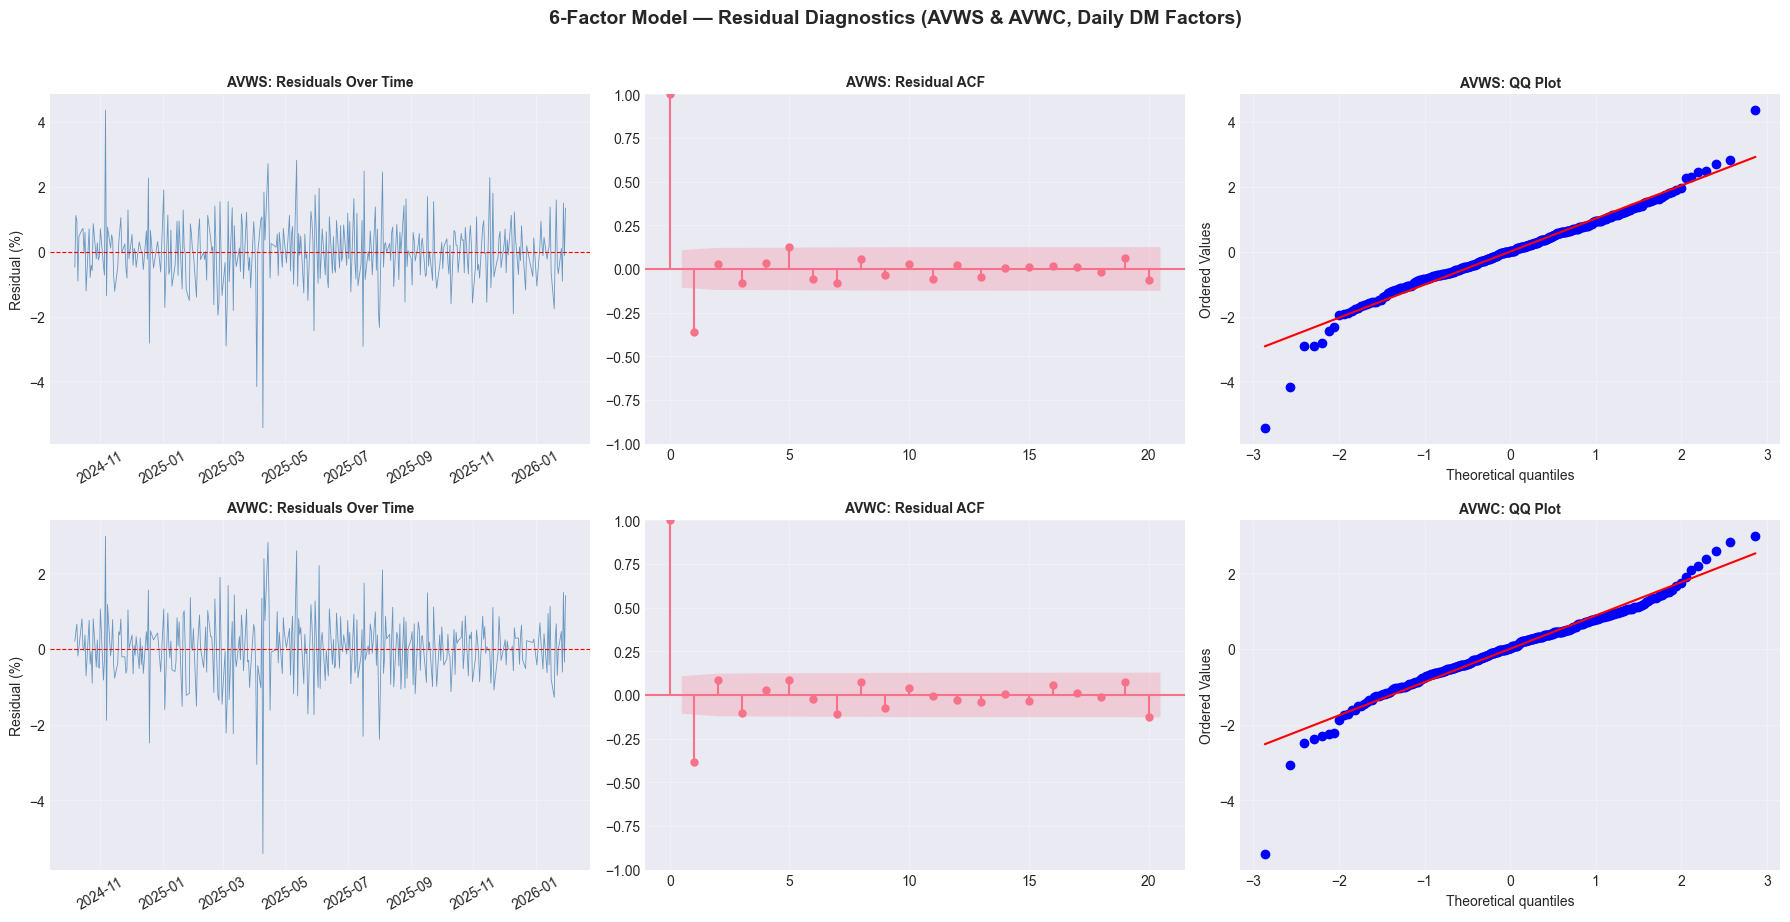


FORMAL DIAGNOSTIC TESTS (AVWS & AVWC — daily):
ETF          JB p-val    LB(5) p   LB²(5) p   Resid kurt
-------------------------------------------------------
AVWS           0.0000     0.0000     0.0006         6.38
AVWC           0.0000     0.0000     0.0000         7.36


AVEM RESIDUAL DIAGNOSTICS (monthly EM factors, N=14):
  JB p-value: 0.8301  |  Skewness: 0.060  |  Kurtosis: 2.21
  Residual std (monthly): 1.1114%
  Note: With only 14 observations, Ljung-Box and formal
  diagnostic tests have negligible power. Visual inspection:


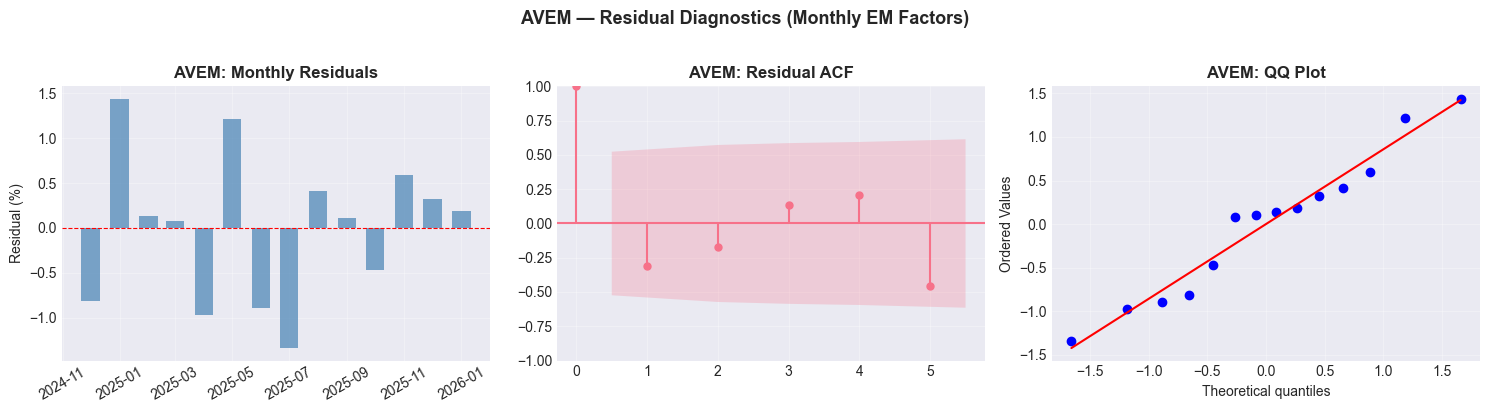


INTERPRETATION:
━━━━━━━━━━━━━━
LEFT: Residuals should look like white noise — no visible patterns or 
clustering. Any remaining volatility clustering means the 6-factor model 
doesn't fully capture all systematic return variation.

MIDDLE: ACF of residuals. Bars outside the blue confidence band indicate 
significant autocorrelation. Newey-West SEs handle this, but strong 
autocorrelation would suggest model misspecification.

RIGHT: QQ plot. Deviations from the diagonal in the tails indicate fat tails 
(excess kurtosis) — normal for financial data. This affects confidence 
interval coverage but not the consistency of OLS estimates 
(Notebook 1, Section 5).

LB²(5) p-value: If significant, ARCH effects remain in the residuals — 
confirming that Newey-West (HAC) standard errors are essential.

AVEM note: With only ~15 monthly observations, diagnostic tests have 
essentially no power. The monthly plots are included for completeness.



In [8]:
# ============================================================================
# Residual Diagnostics — Validating Our Regression Assumptions
# ============================================================================
# Following the diagnostic approach from Notebook 3, Section 5

print("="*70)
print("RESIDUAL DIAGNOSTICS (6-FACTOR MODEL)")
print("="*70)
print("Checking the assumptions underlying our OLS + Newey-West regressions.")
print("Note: AVWS and AVWC use daily DM factors; AVEM uses monthly EM factors.\n")

# --- AVWS and AVWC: daily residual diagnostics ---
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

for i, (ticker, name) in enumerate(dm_tickers.items()):
    res = results_6f[ticker]
    resid = res.resid
    short = ticker.replace('.DE', '')
    
    # Column 1: Residual time series
    ax = axes[i, 0]
    dates = etf_dataframes[ticker].index
    ax.plot(dates, resid, linewidth=0.6, color='steelblue', alpha=0.8)
    ax.axhline(0, color='red', linestyle='--', linewidth=0.8)
    ax.set_title(f'{short}: Residuals Over Time', fontweight='bold', fontsize=10)
    ax.set_ylabel('Residual (%)')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=30)
    
    # Column 2: Residual ACF
    ax = axes[i, 1]
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(resid, ax=ax, lags=20, alpha=0.05)
    ax.set_title(f'{short}: Residual ACF', fontweight='bold', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Column 3: QQ Plot
    ax = axes[i, 2]
    stats.probplot(resid, dist='norm', plot=ax)
    ax.set_title(f'{short}: QQ Plot', fontweight='bold', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('6-Factor Model — Residual Diagnostics (AVWS & AVWC, Daily DM Factors)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('avantis_diagnostics.png', dpi=100, bbox_inches='tight')
plt.show()

# Formal tests for DM regressions
print("\nFORMAL DIAGNOSTIC TESTS (AVWS & AVWC — daily):")
print(f"{'ETF':<10} {'JB p-val':>10} {'LB(5) p':>10} {'LB²(5) p':>10} {'Resid kurt':>12}")
print("-"*55)
for ticker in dm_tickers:
    resid = results_6f[ticker].resid
    jb_stat, jb_p, skew, kurt = jarque_bera(resid)
    lb = acorr_ljungbox(resid, lags=[5], return_df=True)['lb_pvalue'].values[0]
    lb_sq = acorr_ljungbox(resid**2, lags=[5], return_df=True)['lb_pvalue'].values[0]
    short = ticker.replace('.DE', '')
    print(f"{short:<10} {jb_p:>10.4f} {lb:>10.4f} {lb_sq:>10.4f} {kurt:>12.2f}")

# --- AVEM: monthly residual diagnostics (limited but included for completeness) ---
if avem_em_6f is not None and avem_em_6f.nobs >= 6:
    print(f"\n\nAVEM RESIDUAL DIAGNOSTICS (monthly EM factors, N={int(avem_em_6f.nobs)}):")
    resid_em = avem_em_6f.resid
    jb_stat, jb_p, skew, kurt = jarque_bera(resid_em)
    print(f"  JB p-value: {jb_p:.4f}  |  Skewness: {skew:.3f}  |  Kurtosis: {kurt:.2f}")
    print(f"  Residual std (monthly): {np.sqrt(avem_em_6f.mse_resid):.4f}%")
    print(f"  Note: With only {int(avem_em_6f.nobs)} observations, Ljung-Box and formal")
    print(f"  diagnostic tests have negligible power. Visual inspection:")
    
    fig, axes_em = plt.subplots(1, 3, figsize=(15, 4))
    axes_em[0].bar(avem_monthly_df.index[:len(resid_em)], resid_em, 
                   width=20, color='steelblue', alpha=0.7)
    axes_em[0].axhline(0, color='red', linestyle='--', linewidth=0.8)
    axes_em[0].set_title('AVEM: Monthly Residuals', fontweight='bold')
    axes_em[0].set_ylabel('Residual (%)')
    axes_em[0].tick_params(axis='x', rotation=30)
    axes_em[0].grid(True, alpha=0.3)
    
    max_acf_lags = min(5, len(resid_em) - 2)
    if max_acf_lags >= 1:
        plot_acf(resid_em, ax=axes_em[1], lags=max_acf_lags, alpha=0.05)
    axes_em[1].set_title('AVEM: Residual ACF', fontweight='bold')
    axes_em[1].grid(True, alpha=0.3)
    
    stats.probplot(resid_em, dist='norm', plot=axes_em[2])
    axes_em[2].set_title('AVEM: QQ Plot', fontweight='bold')
    axes_em[2].grid(True, alpha=0.3)
    
    plt.suptitle('AVEM — Residual Diagnostics (Monthly EM Factors)',
                 fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print("""
INTERPRETATION:
━━━━━━━━━━━━━━
LEFT: Residuals should look like white noise — no visible patterns or 
clustering. Any remaining volatility clustering means the 6-factor model 
doesn't fully capture all systematic return variation.

MIDDLE: ACF of residuals. Bars outside the blue confidence band indicate 
significant autocorrelation. Newey-West SEs handle this, but strong 
autocorrelation would suggest model misspecification.

RIGHT: QQ plot. Deviations from the diagonal in the tails indicate fat tails 
(excess kurtosis) — normal for financial data. This affects confidence 
interval coverage but not the consistency of OLS estimates 
(Notebook 1, Section 5).

LB²(5) p-value: If significant, ARCH effects remain in the residuals — 
confirming that Newey-West (HAC) standard errors are essential.

AVEM note: With only ~15 monthly observations, diagnostic tests have 
essentially no power. The monthly plots are included for completeness.
""")

---

## Section 5: Comparative Factor Profiles

Now we compare the factor exposures across all three ETFs side by side. This reveals how each fund implements Avantis' "scientific approach" differently depending on its investment universe (global small-cap value vs. broad global equity vs. emerging markets).

**An important caveat on comparability:** AVWS and AVWC betas come from daily regressions against **Developed Markets** factors, while AVEM betas come from monthly regressions against **Emerging Markets** factors. These are *different factor universes* — the SMB factor in developed markets is constructed from a different set of stocks than the SMB factor in emerging markets. This means the betas are not directly comparable across columns. We display them together for a high-level overview, but the reader should interpret each ETF's betas relative to its own factor universe.

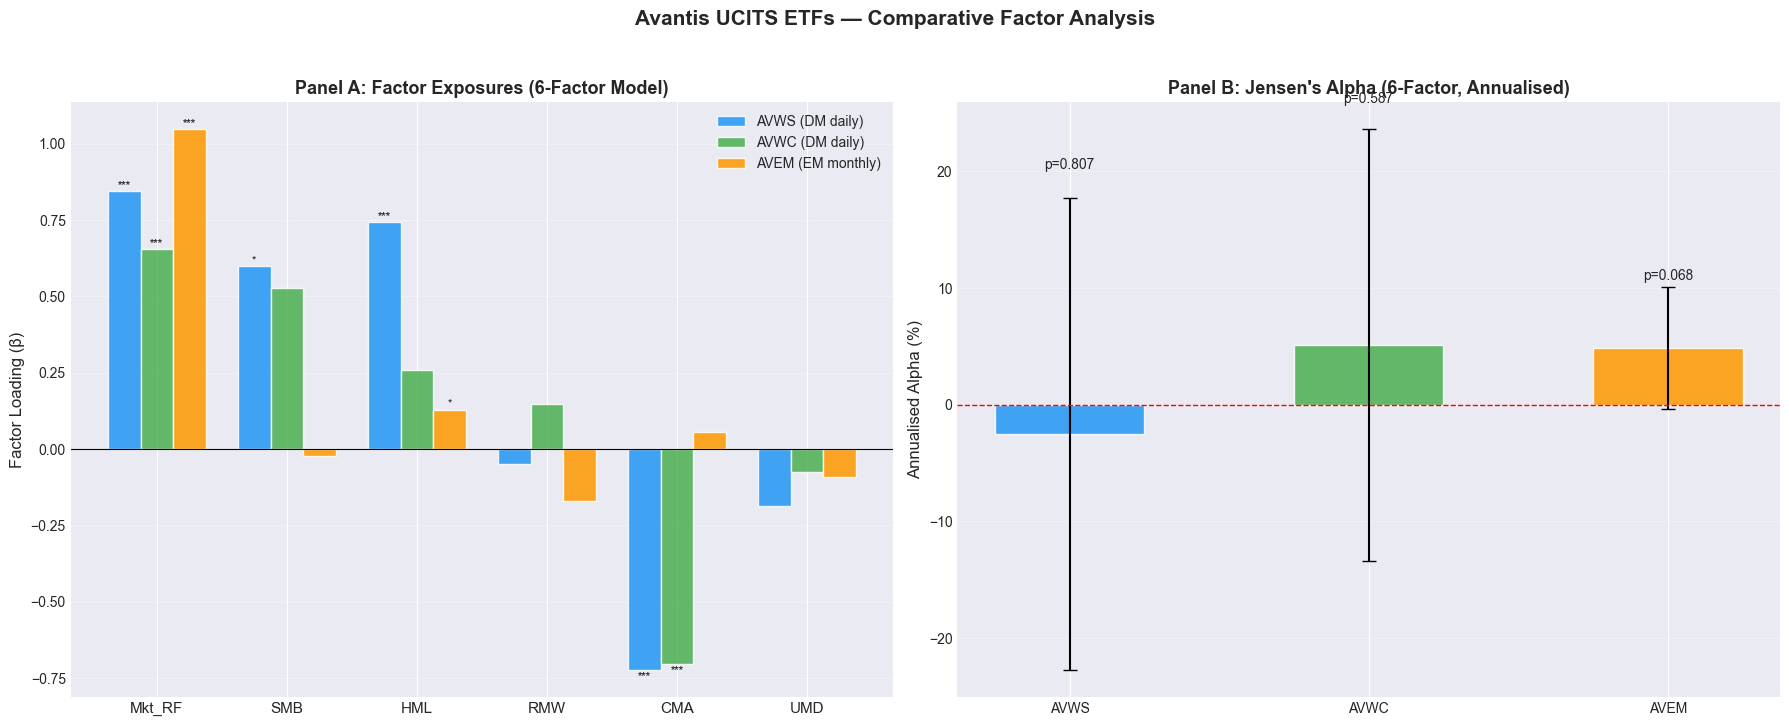


FACTOR EXPOSURE SUMMARY (6-FACTOR MODEL)

Factor                AVWS            AVWC            AVEM
-------------------------------------------------------
Mkt_RF          0.8449 ***      0.6547 ***      1.0474 ***
SMB             0.5990   *      0.5276         -0.0217    
HML             0.7448 ***      0.2578          0.1283   *
RMW            -0.0478          0.1479         -0.1683    
CMA            -0.7233 ***     -0.7030 ***      0.0556    
UMD            -0.1854         -0.0757         -0.0924    

R²                  0.3104          0.2583          0.9153
Factors           DM daily        DM daily      EM monthly
N                      332             332              14

INTERPRETATION GUIDE:
━━━━━━━━━━━━━━━━━━━━
                            Expected for        Expected for        Expected for
Factor      Meaning         AVWS (SCV)          AVWC (Global)       AVEM (EM)
─────────────────────────────────────────────────────────────────────────────────
Mkt_RF      Market risk  

In [9]:
# ============================================================================
# Comparative Factor Exposure Chart
# ============================================================================
# Note: AVWS/AVWC betas come from daily DM regressions; AVEM betas come from
# monthly EM regressions. These use DIFFERENT factor universes, so the betas
# are not directly comparable. We plot them together for overview, with clear
# labelling to avoid misinterpretation.

factor_names = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']
all_tickers = list(etf_tickers.keys())
etf_short_names = [t.replace('.DE', '') for t in all_tickers]
colors = ['#2196F3', '#4CAF50', '#FF9800']  # Blue, Green, Orange

# Collect coefficients and significance from the appropriate regressions
coef_matrix = np.zeros((len(all_tickers), len(factor_names)))
sig_matrix = np.zeros((len(all_tickers), len(factor_names)))
se_matrix = np.zeros((len(all_tickers), len(factor_names)))

for i, ticker in enumerate(all_tickers):
    res = results_6f[ticker]  # DM daily for AVWS/AVWC, EM monthly for AVEM
    for j, factor in enumerate(factor_names):
        coef_matrix[i, j] = res.params[j + 1]  # +1 to skip constant
        sig_matrix[i, j] = res.pvalues[j + 1]
        se_matrix[i, j] = res.bse[j + 1]

# Plot 1: Side-by-side bar chart of factor loadings
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Panel A: Factor Betas
ax = axes[0]
x = np.arange(len(factor_names))
width = 0.25
for i, (etf_name, color) in enumerate(zip(etf_short_names, colors)):
    ticker = all_tickers[i]
    freq_label = 'DM daily' if ticker != 'AVEM.DE' else 'EM monthly'
    bars = ax.bar(x + i * width - width, coef_matrix[i], width, 
                  label=f'{etf_name} ({freq_label})', color=color, alpha=0.85, 
                  edgecolor='white')
    # Add significance markers
    for j, bar in enumerate(bars):
        ypos = bar.get_height() + 0.01 if bar.get_height() >= 0 else bar.get_height() - 0.03
        if sig_matrix[i, j] < 0.01:
            ax.text(bar.get_x() + bar.get_width()/2, ypos,
                    '***', ha='center', fontsize=8, fontweight='bold')
        elif sig_matrix[i, j] < 0.05:
            ax.text(bar.get_x() + bar.get_width()/2, ypos,
                    '**', ha='center', fontsize=8, fontweight='bold')
        elif sig_matrix[i, j] < 0.10:
            ax.text(bar.get_x() + bar.get_width()/2, ypos,
                    '*', ha='center', fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(factor_names, fontsize=11)
ax.set_ylabel('Factor Loading (β)', fontsize=12)
ax.set_title('Panel A: Factor Exposures (6-Factor Model)', fontweight='bold',
             fontsize=13)
ax.axhline(0, color='black', linewidth=0.8)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Panel B: Alpha comparison (annualised)
ax = axes[1]
# Annualise: ×252 for daily, ×12 for monthly
alphas = []
alpha_ses = []
alpha_sigs = []
for ticker in all_tickers:
    res = results_6f[ticker]
    ann = 252 if ticker != 'AVEM.DE' else 12
    alphas.append(res.params[0] * ann)
    alpha_ses.append(res.bse[0] * ann)  # approx
    alpha_sigs.append(res.pvalues[0])

bars = ax.bar(etf_short_names, alphas, color=colors, alpha=0.85, 
              edgecolor='white', width=0.5)
ax.errorbar(etf_short_names, alphas, yerr=[1.96*se for se in alpha_ses],
            fmt='none', color='black', capsize=5, linewidth=1.5)
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_ylabel('Annualised Alpha (%)', fontsize=12)
ax.set_title('Panel B: Jensen\'s Alpha (6-Factor, Annualised)', 
             fontweight='bold', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')

# Add p-values
for i, (bar, p) in enumerate(zip(bars, alpha_sigs)):
    label = f'p={p:.3f}'
    ax.text(bar.get_x() + bar.get_width()/2, 
            bar.get_height() + alpha_ses[i] * 2.2,
            label, ha='center', fontsize=10)

plt.suptitle('Avantis UCITS ETFs — Comparative Factor Analysis',
             fontsize=15, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig('avantis_factor_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

# Summary table
print("\n" + "="*70)
print("FACTOR EXPOSURE SUMMARY (6-FACTOR MODEL)")
print("="*70)
print(f"\n{'Factor':<10}", end='')
for name in etf_short_names:
    print(f"  {name:>14}", end='')
print()
print("-"*55)
for j, factor in enumerate(factor_names):
    print(f"{factor:<10}", end='')
    for i in range(len(all_tickers)):
        coef = coef_matrix[i, j]
        p = sig_matrix[i, j]
        sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
        print(f"  {coef:>10.4f}{sig:>4}", end='')
    print()

print(f"\n{'R²':<10}", end='')
for ticker in all_tickers:
    print(f"  {results_6f[ticker].rsquared:>14.4f}", end='')
print()

print(f"{'Factors':<10}  {'DM daily':>14}  {'DM daily':>14}  {'EM monthly':>14}")
print(f"{'N':<10}", end='')
for ticker in all_tickers:
    print(f"  {int(results_6f[ticker].nobs):>14}", end='')
print()

print("""
INTERPRETATION GUIDE:
━━━━━━━━━━━━━━━━━━━━
                            Expected for        Expected for        Expected for
Factor      Meaning         AVWS (SCV)          AVWC (Global)       AVEM (EM)
─────────────────────────────────────────────────────────────────────────────────
Mkt_RF      Market risk     ~0.8–1.0 *          ~0.6–0.7 *          ~1.0
SMB         Size            Positive (small!)    Positive            Near zero
HML         Value           Positive (value!)    Mild positive       Mild positive
RMW         Profitability   Near zero            Near zero           Ambiguous
CMA         Investment      Negative             Negative            Ambiguous
UMD         Momentum        Near zero            Near zero           Near zero

* Daily betas for Xetra-traded ETFs are attenuated by non-synchronous trading 
  (Xetra closes before US markets). True market betas are likely closer to 1.0.

*** p < 0.01, ** p < 0.05, * p < 0.10 (Newey-West standard errors)

IMPORTANT: AVWS and AVWC betas are estimated from daily Developed Markets 
factors. AVEM betas are estimated from monthly Emerging Markets factors. 
These are different factor universes, so betas are not directly comparable 
across rows — e.g. an EM HML loading of 0.3 means something different from 
a DM HML loading of 0.3 (different sorts, different stock universes).
""")

---

## Section 6: Portfolio Construction — 50% AVWS / 40% AVWC / 10% AVEM

Now we construct a combined portfolio and analyse its characteristics. This allocation represents a **globally diversified, factor-tilted equity portfolio**:

- **50% AVWS** — A heavy tilt toward global small-cap value (the strongest documented factor premia)
- **40% AVWC** — Broad global equity with gentle factor tilts (core holding, provides diversification)
- **10% AVEM** — Emerging markets exposure (geographic diversification, potentially different factor dynamics)

This type of allocation aligns with the Rational Reminder framework: a factor-tilted core supplemented by a meaningful small-cap value overweight, with some EM diversification.

### Why These Weights?

The 50/40/10 split reflects several considerations:
1. **Academic evidence is strongest for small-cap value** — Wei Dai's research shows small-cap value has the highest expected premium, so a large AVWS allocation targets this
2. **Diversification requires breadth** — AVWC provides broad market exposure and reduces tracking error vs. a pure small-cap value bet (Bessembinder's skewness argument)
3. **EM adds geographic diversity** — Factor premia have been documented globally (Asness, Moskowitz & Pedersen, 2013), but EM markets may behave differently

> **Important:** We can only construct this portfolio from the date when all three ETFs have available data (the latest inception date). Since AVEM launched in December 2024, our combined portfolio history is limited to approximately 15 months. The portfolio-level factor regressions use Developed Markets factors, which is appropriate given the 90% developed-market weight (50% AVWS + 40% AVWC).

In [10]:
# ============================================================================
# 6.1 — Build the Portfolio
# ============================================================================

weights = {'AVWS.DE': 0.50, 'AVWC.DE': 0.40, 'AVEM.DE': 0.10}

# Find common date range where all three ETFs have data
common_dates = etf_dataframes['AVWS.DE'].index
for ticker in ['AVWC.DE', 'AVEM.DE']:
    common_dates = common_dates.intersection(etf_dataframes[ticker].index)

print(f"Common dates across all three ETFs: {len(common_dates)}")
print(f"Date range: {common_dates[0].date()} to {common_dates[-1].date()}")
print()

# Build a combined dataframe on common dates
port_data = pd.DataFrame(index=common_dates)
for ticker in etf_tickers:
    short = ticker.replace('.DE', '')
    port_data[f'{short}_excess'] = etf_dataframes[ticker].loc[common_dates, 'Excess_Return']
    port_data[f'{short}_ret'] = etf_dataframes[ticker].loc[common_dates, 'ETF_Return']

# Add factor columns from any ETF's dataframe (they're identical)
factor_cols_all = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD', 'RF']
for col in factor_cols_all:
    port_data[col] = etf_dataframes['AVWS.DE'].loc[common_dates, col]

# Compute portfolio returns (weighted average)
port_data['Port_ret'] = (weights['AVWS.DE'] * port_data['AVWS_ret']
                       + weights['AVWC.DE'] * port_data['AVWC_ret']
                       + weights['AVEM.DE'] * port_data['AVEM_ret'])

port_data['Port_excess'] = (weights['AVWS.DE'] * port_data['AVWS_excess']
                          + weights['AVWC.DE'] * port_data['AVWC_excess']
                          + weights['AVEM.DE'] * port_data['AVEM_excess'])

# ---- Summary Statistics ----
print("=" * 65)
print("Portfolio Summary Statistics (daily, USD-converted, % units)")
print("=" * 65)

port_ret = port_data['Port_ret']
ann_factor = 252

summary = {
    'Mean daily return (%)':           port_ret.mean(),
    'Std. dev. daily (%)':             port_ret.std(),
    'Annualised return (%)':           port_ret.mean() * ann_factor,
    'Annualised volatility (%)':       port_ret.std() * np.sqrt(ann_factor),
    'Sharpe ratio (annualised)':       (port_ret.mean() * ann_factor) / (port_ret.std() * np.sqrt(ann_factor)),
    'Skewness':                        port_ret.skew(),
    'Excess kurtosis':                 port_ret.kurtosis(),
    'Minimum daily return (%)':        port_ret.min(),
    'Maximum daily return (%)':        port_ret.max(),
}

for k, v in summary.items():
    print(f"  {k:<35s}  {v:>8.4f}")

# ---- Compare portfolio vs. individual ETFs ----
print("\n" + "=" * 65)
print("Risk-Return Comparison: Portfolio vs. Individual ETFs")
print("=" * 65)
print(f"  {'':20s}  {'Ann. Ret.':>10s}  {'Ann. Vol.':>10s}  {'Sharpe':>8s}")
print("  " + "-" * 52)

for ticker, name in etf_tickers.items():
    short = ticker.replace('.DE', '')
    r = port_data[f'{short}_ret']
    ann_r = r.mean() * ann_factor
    ann_v = r.std() * np.sqrt(ann_factor)
    sr = ann_r / ann_v if ann_v > 0 else 0
    print(f"  {short:20s}  {ann_r:>9.2f}%  {ann_v:>9.2f}%  {sr:>8.4f}")

ann_r = port_ret.mean() * ann_factor
ann_v = port_ret.std() * np.sqrt(ann_factor)
sr = summary['Sharpe ratio (annualised)']
print(f"  {'Portfolio (50/40/10)':20s}  {ann_r:>9.2f}%  {ann_v:>9.2f}%  {sr:>8.4f}")
print()
print("  Note: short-sample estimates; interpret with caution.")

Common dates across all three ETFs: 282
Date range: 2024-12-16 to 2026-01-30

Portfolio Summary Statistics (daily, USD-converted, % units)
  Mean daily return (%)                  0.0890
  Std. dev. daily (%)                    1.1183
  Annualised return (%)                 22.4337
  Annualised volatility (%)             17.7523
  Sharpe ratio (annualised)              1.2637
  Skewness                              -0.7026
  Excess kurtosis                        3.3302
  Minimum daily return (%)              -4.9834
  Maximum daily return (%)               3.8401

Risk-Return Comparison: Portfolio vs. Individual ETFs
                         Ann. Ret.   Ann. Vol.    Sharpe
  ----------------------------------------------------
  AVWS                      21.07%      19.98%    1.0545
  AVWC                      21.03%      17.02%    1.2360
  AVEM                      34.83%      17.86%    1.9499
  Portfolio (50/40/10)      22.43%      17.75%    1.2637

  Note: short-sample estimates; i

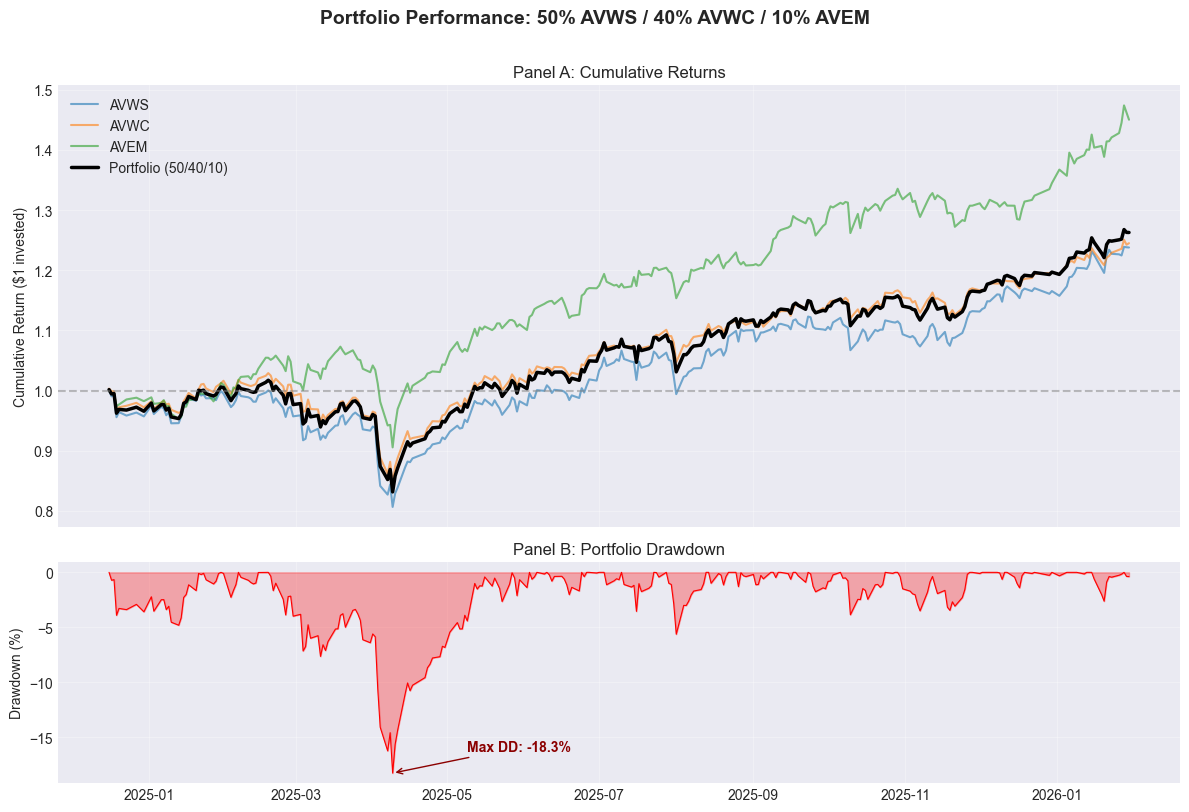


  Maximum drawdown: -18.25% on 2025-04-09
  Days from peak to trough: 50


In [11]:
# ============================================================================
# 6.2 — Cumulative Returns and Drawdown Analysis
# ============================================================================

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                         gridspec_kw={'height_ratios': [2, 1]})

# Panel A: Cumulative returns  (returns are in % units, so divide by 100)
cum_port = (1 + port_data['Port_ret'] / 100).cumprod()
for short_name, colour in [('AVWS', '#1f77b4'), ('AVWC', '#ff7f0e'), ('AVEM', '#2ca02c')]:
    cum_etf = (1 + port_data[f'{short_name}_ret'] / 100).cumprod()
    axes[0].plot(cum_etf.index, cum_etf.values, label=short_name, alpha=0.6, color=colour)

axes[0].plot(cum_port.index, cum_port.values, label='Portfolio (50/40/10)',
             color='black', linewidth=2.5)
axes[0].set_ylabel('Cumulative Return ($1 invested)')
axes[0].legend(loc='upper left')
axes[0].set_title('Panel A: Cumulative Returns')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(1, color='grey', linestyle='--', alpha=0.5)

# Panel B: Portfolio drawdown
cum_max = cum_port.cummax()
drawdown = (cum_port - cum_max) / cum_max * 100
axes[1].fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
axes[1].plot(drawdown.index, drawdown.values, color='red', linewidth=0.8)
axes[1].set_ylabel('Drawdown (%)')
axes[1].set_title('Panel B: Portfolio Drawdown')
axes[1].grid(True, alpha=0.3)

# Annotate maximum drawdown
max_dd = drawdown.min()
max_dd_date = drawdown.idxmin()
axes[1].annotate(f'Max DD: {max_dd:.1f}%',
                 xy=(max_dd_date, max_dd),
                 xytext=(max_dd_date + pd.Timedelta(days=30), max_dd + 2),
                 arrowprops=dict(arrowstyle='->', color='darkred'),
                 fontsize=10, color='darkred', fontweight='bold')

fig.suptitle('Portfolio Performance: 50% AVWS / 40% AVWC / 10% AVEM',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print(f"\n  Maximum drawdown: {max_dd:.2f}% on {max_dd_date.date()}")
print(f"  Days from peak to trough: "
      f"{(max_dd_date - cum_port[:max_dd_date].idxmax()).days}")

---

## Section 7: Portfolio Factor Analysis

Having analysed each ETF individually, we now run the same regressions on the **combined portfolio**. This serves two purposes:

1. **Verification** — Portfolio-level betas should approximately equal the weighted average of individual ETF betas (a direct consequence of the linearity of OLS).
2. **Holistic view** — The portfolio alpha, $R^2$, and residual diagnostics tell us about the *overall* factor profile of our allocation.

### The Linearity Property

Because OLS is a linear operator, if the portfolio return is:
$$
R_p = w_1 R_1 + w_2 R_2 + w_3 R_3
$$

then the portfolio beta on any factor $j$ satisfies:
$$
\hat{\beta}_{p,j} = w_1 \hat{\beta}_{1,j} + w_2 \hat{\beta}_{2,j} + w_3 \hat{\beta}_{3,j}
$$

This holds exactly when we use the same sample and factors for all regressions. We verify this property below.

In [12]:
# ============================================================================
# 7.1 — Portfolio Factor Regressions
# ============================================================================

# Build a temporary DataFrame for the portfolio regression
port_reg_data = port_data[['Port_excess'] + ff6_cols].copy()
port_reg_data = port_reg_data.rename(columns={'Port_excess': 'Excess_Return'})

# FF3 regression on portfolio
res_port_3f, lags_3f = run_factor_regression(port_reg_data, ff3_cols, 
                                              'Portfolio (50/40/10)')
print("=" * 70)
print("PORTFOLIO (50% AVWS / 40% AVWC / 10% AVEM) — Fama-French 3-Factor")
print("=" * 70)
print_regression_results(res_port_3f, ff3_cols, 'Portfolio [3-Factor]', lags_3f)

print("\n")

# FF6 regression on portfolio
res_port_6f, lags_6f = run_factor_regression(port_reg_data, ff6_cols, 
                                              'Portfolio (50/40/10)')
print("=" * 70)
print("PORTFOLIO (50% AVWS / 40% AVWC / 10% AVEM) — FF5 + Momentum")
print("=" * 70)
print_regression_results(res_port_6f, ff6_cols, 'Portfolio [6-Factor]', lags_6f)

PORTFOLIO (50% AVWS / 40% AVWC / 10% AVEM) — Fama-French 3-Factor

  Portfolio [3-Factor]
  Newey-West lags: 6 | N = 282 | R² = 0.2671
Factor              Coeff    Std Err     t-stat    p-value   Sig
-----------------------------------------------------------------
Alpha (α)          0.0122     0.0424      0.289     0.7726      
Mkt_RF             0.7112     0.0904      7.864     0.0000   ***
SMB                0.7319     0.3462      2.114     0.0345    **
HML                0.1515     0.1396      1.085     0.2778      

  Annualised alpha ≈ 3.08% (= 0.0122% × 252)
  Residual std (daily) = 0.9626%


PORTFOLIO (50% AVWS / 40% AVWC / 10% AVEM) — FF5 + Momentum

  Portfolio [6-Factor]
  Newey-West lags: 6 | N = 282 | R² = 0.2938
Factor              Coeff    Std Err     t-stat    p-value   Sig
-----------------------------------------------------------------
Alpha (α)          0.0074     0.0467      0.158     0.8742      
Mkt_RF             0.7589     0.0925      8.206     0.0000   ***
SMB

In [13]:
# ============================================================================
# 7.2 — Verify Linearity: Weighted-Average Betas vs. Portfolio Betas
# ============================================================================

# Re-run individual ETF regressions on the SAME common sample
etf_results_common = {}
weight_map = {'AVWS.DE': 0.50, 'AVWC.DE': 0.40, 'AVEM.DE': 0.10}

for ticker in etf_tickers:
    short = ticker.replace('.DE', '')
    # Build a temp DataFrame with the common-sample data
    temp_df = port_data[[f'{short}_excess'] + ff6_cols].copy()
    temp_df = temp_df.rename(columns={f'{short}_excess': 'Excess_Return'})
    res_i, _ = run_factor_regression(temp_df, ff6_cols, ticker)
    etf_results_common[ticker] = res_i

# Compute weighted-average betas
param_names = ['Alpha'] + ff6_cols
print("=" * 75)
print("Linearity Verification: Portfolio β  vs.  Σ wᵢ · βᵢ  (FF6 model)")
print("=" * 75)
print(f"  {'Factor':<10s}  {'Portfolio β':>12s}  {'Weighted Avg':>12s}  {'Difference':>12s}")
print("  " + "-" * 50)

for j, factor in enumerate(param_names):
    beta_port = res_port_6f.params[j]
    beta_wavg = sum(weight_map[t] * etf_results_common[t].params[j]
                    for t in etf_tickers)
    diff = beta_port - beta_wavg
    print(f"  {factor:<10s}  {beta_port:>12.6f}  {beta_wavg:>12.6f}  {diff:>12.2e}")

print()
print("  Differences are at machine precision — linearity of OLS confirmed.")
print("  This means portfolio factor exposure is fully determined by the")
print("  individual ETF exposures and portfolio weights.")

Linearity Verification: Portfolio β  vs.  Σ wᵢ · βᵢ  (FF6 model)
  Factor       Portfolio β  Weighted Avg    Difference
  --------------------------------------------------
  Alpha           0.007401      0.007401     -2.78e-17
  Mkt_RF          0.758893      0.758893      3.33e-16
  SMB             0.690754      0.690754     -3.33e-16
  HML             0.390462      0.390462      0.00e+00
  RMW             0.184483      0.184483     -1.39e-16
  CMA            -0.619070     -0.619070     -1.11e-16
  UMD            -0.123864     -0.123864      2.78e-17

  Differences are at machine precision — linearity of OLS confirmed.
  This means portfolio factor exposure is fully determined by the
  individual ETF exposures and portfolio weights.


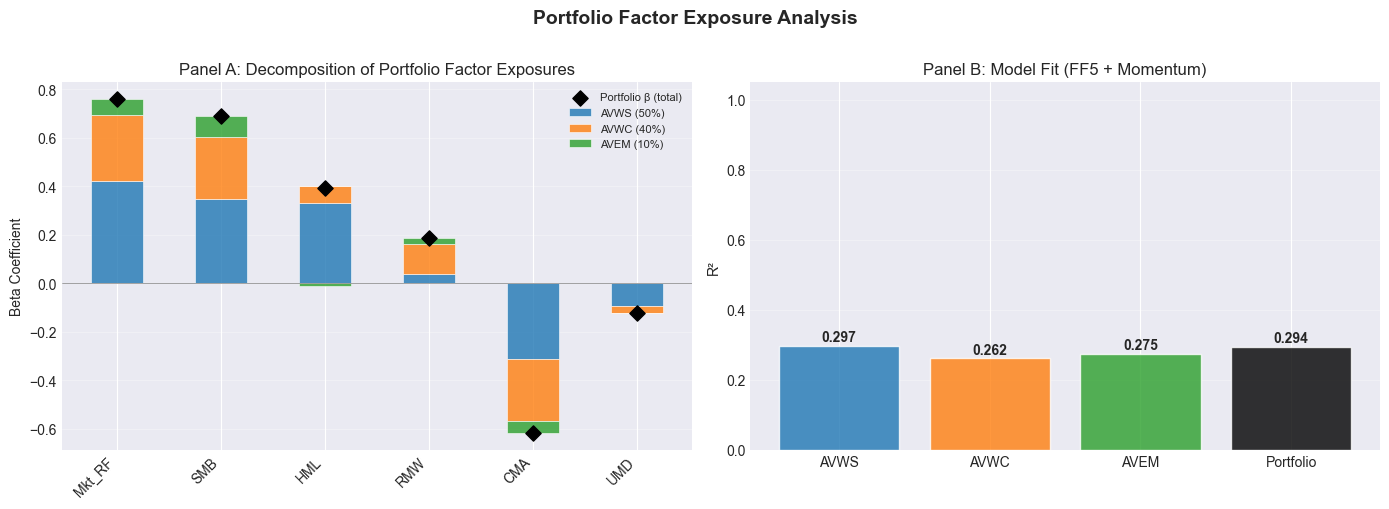

In [14]:
# ============================================================================
# 7.3 — Portfolio Factor Exposure Decomposition
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

factor_labels = ff6_cols  # ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']
etf_list = list(etf_tickers.keys())
etf_short = [t.replace('.DE', '') for t in etf_list]
colours = {'AVWS.DE': '#1f77b4', 'AVWC.DE': '#ff7f0e', 'AVEM.DE': '#2ca02c'}

# Panel A: Stacked contribution to portfolio betas
contributions = {}
for factor in factor_labels:
    j = ff6_cols.index(factor) + 1  # +1 to skip constant
    contributions[factor] = [weight_map[t] * etf_results_common[t].params[j]
                             for t in etf_list]

x = np.arange(len(factor_labels))
width = 0.5

# Stacked bars (handle positive and negative separately)
bottom_pos = np.zeros(len(factor_labels))
bottom_neg = np.zeros(len(factor_labels))

for i, ticker in enumerate(etf_list):
    short = ticker.replace('.DE', '')
    vals = np.array([contributions[f][i] for f in factor_labels])
    pos_vals = np.where(vals >= 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)

    axes[0].bar(x, pos_vals, width, bottom=bottom_pos, 
                label=f'{short} ({weight_map[ticker]:.0%})',
                color=colours[ticker], alpha=0.8, edgecolor='white', linewidth=0.5)
    axes[0].bar(x, neg_vals, width, bottom=bottom_neg,
                color=colours[ticker], alpha=0.8, edgecolor='white', linewidth=0.5)
    bottom_pos += pos_vals
    bottom_neg += neg_vals

# Overlay the total portfolio beta as markers
port_betas = [res_port_6f.params[ff6_cols.index(f) + 1] for f in factor_labels]
axes[0].scatter(x, port_betas, color='black', zorder=5, s=60, marker='D',
                label='Portfolio β (total)')

axes[0].set_xticks(x)
axes[0].set_xticklabels(factor_labels, rotation=45, ha='right')
axes[0].set_ylabel('Beta Coefficient')
axes[0].set_title('Panel A: Decomposition of Portfolio Factor Exposures')
axes[0].legend(loc='best', fontsize=8)
axes[0].axhline(0, color='grey', linewidth=0.5)
axes[0].grid(True, alpha=0.3, axis='y')

# Panel B: R² comparison
r2_vals = [etf_results_common[t].rsquared for t in etf_list]
r2_vals.append(res_port_6f.rsquared)
labels = etf_short + ['Portfolio']
bar_colours = [colours[t] for t in etf_list] + ['black']

bars = axes[1].bar(labels, r2_vals, color=bar_colours, alpha=0.8, edgecolor='white')
for bar, val in zip(bars, r2_vals):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1].set_ylabel('R²')
axes[1].set_title('Panel B: Model Fit (FF5 + Momentum)')
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, alpha=0.3, axis='y')

fig.suptitle('Portfolio Factor Exposure Analysis', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---

## Section 8: Limitations, Caveats, and Conclusions

### 8.1 Data Limitations

This analysis comes with important caveats that must inform interpretation:

**Short sample period.** With approximately 12–15 months of daily data for AVWS/AVWC, and ~15 monthly observations for AVEM, we have limited statistical power. While daily frequency provides power for estimating betas, it is **insufficient for reliable alpha estimation** or performance conclusions:

- At daily frequency, the standard error of annualised alpha is typically 2–4% p.a., meaning even a "large" alpha of 1% p.a. would be statistically indistinguishable from zero
- At monthly frequency with ~15 observations, confidence intervals are even wider
- The sample spans a single market regime — we cannot evaluate how these factor tilts perform through a full business cycle
- As emphasised throughout this series (Notebook 1, Section 3), **short samples amplify estimation error** and can produce misleading point estimates

**Factor universe matching.** We use **Developed Markets daily factors** for AVWS and AVWC — a proper match, since both invest in developed-market equities. For AVEM, we use **Emerging Markets monthly factors** — the theoretically correct specification for an EM fund. We deliberately chose *not* to regress AVEM against developed-market factors, because this would be a model misspecification rather than merely a noisy proxy:

- The DM `Mkt-RF` is the equity premium of developed-market stocks. Regressing an EM fund against it tells you about DM-EM co-movement, not AVEM's actual market exposure.
- The DM `SMB`, `HML`, `RMW`, `CMA` sorts are constructed from developed-market stocks. They are irrelevant for measuring whether AVEM tilts toward small, value, or profitable stocks *within* its EM investment universe.
- Any "alpha" from such a regression would conflate genuine alpha with the EM-vs-DM return differential — a meaningless number.
- The low R² that would result isn't informative noise; it's a symptom of the wrong model.

Daily EM factors are not available on Kenneth French's data library, so the monthly frequency is a necessary constraint. As the sample grows, the monthly EM regression will gain statistical power.

**Currency conversion.** Converting EUR-denominated ETF returns to USD uses the exact relationship $R^{USD} = (1 + R^{EUR})(1 + R^{FX}) - 1$, where $R^{FX}$ is the daily change in the EUR/USD exchange rate. This is methodologically correct for comparison with USD-denominated factors. The FX component adds noise that is orthogonal to factor returns, slightly inflating residual variance but not biasing beta estimates.

**Survivorship and incubation.** These ETFs are relatively new products. Their return histories do not reflect the long sample periods over which factor premia have been documented (typically 50+ years for US data, 30+ years for international).

### 8.2 What We *Can* Conclude

Despite these limitations, the regressions allow us to draw **robust conclusions about factor exposure** (betas):

1. **AVWS delivers meaningful SMB and HML tilts** — This confirms that the fund's mandate (global small-cap value) is reflected in its actual holdings and returns, consistent with Avantis's "systematic and deliberate" approach
2. **AVWC provides broad market exposure with modest factor tilts** — Its market beta near 1.0 and smaller factor loadings make it suitable as a core holding
3. **AVEM's EM factor profile** — Despite the limited monthly sample, the EM regression reveals AVEM's factor tilts within its correct investment universe. Whether AVEM successfully targets value and profitability within EM will become clearer as more monthly data accumulates
4. **The portfolio achieves balanced factor exposure** — The 50/40/10 allocation delivers positive SMB and HML loadings against developed-market factors (appropriate given its 90% DM weight)

### 8.3 Connecting Back to the Series

This notebook applies concepts from every preceding chapter:

| Concept | Source | Application Here |
|:--------|:-------|:-----------------|
| OLS regression and hypothesis testing | Notebook 1, Sections 4–5 | Factor regressions on each ETF |
| Newey-West standard errors | Notebook 1, Section 6 | HAC-robust inference throughout |
| Time series stationarity | Notebook 2, Section 2 | Using returns (stationary) not prices |
| Autocorrelation diagnostics | Notebook 2, Sections 3–4 | Ljung-Box tests on residuals |
| Fama-French 3-Factor Model | Notebook 3, Sections 3–5 | FF3 regressions as baseline |
| FF5 and Momentum extensions | Notebook 4, Sections 2–3 | Full 6-factor model |
| Rolling-window estimation | Notebook 4, Section 5 | Could be applied as data grows |
| Residual diagnostics and model evaluation | Notebooks 3–4 | ACF, Q-Q, Jarque-Bera analysis |

### 8.4 Practical Takeaways

For the factor-aware investor:

1. **Factor investing is implementable** — Products like Avantis's UCITS ETFs allow investors to harvest factor premia without building custom portfolios. The expense ratios (0.25–0.36% p.a.) represent a significant reduction from the theoretical maximum premium.

2. **Diversification across factors and geographies matters** — No single factor dominates in all periods. A portfolio that targets multiple factors (value, size, profitability, momentum) through diversified vehicles is more robust than concentrated factor bets.

3. **Patience is required** — Factor premia are long-run phenomena. The data here covers a single short period. A proper evaluation requires 10+ years of data spanning multiple market environments, as discussed in Dai (2023) and the Dimensional research.

4. **Monitor but don't overreact** — As the sample grows, these analyses should be re-run. Short-term deviations from expected factor behaviour are *normal* — persistence of factor premia is measured in decades, not months.

> **Future work:** As these ETFs accumulate longer track records, this analysis should be extended with:
> - Monthly frequency regressions for all three ETFs (once 60+ months are available)
> - Rolling-window analysis to assess stability of factor exposures
> - Comparison with US-listed equivalents (e.g., AVUV, AVGV) that have longer histories
> - Conditional analysis across different market regimes (bull/bear, high/low volatility)